# Making Jet clusters and exporting them
## Need Aggregator files, SOL_Tc_stats (or T3) and subjects_Tc (or T3) made during the aggregation in BoxTheJets
This notebook takes the jets detected per subjects and looks for clusters in space and time. If two jets of different clusters fall within the epsilon given by the user (set by eps and time_eps) they are clustered together to make a jet cluster, this can be repeated such that more jets are added to the cluster. Clusters can only contain one jet per subject such that closeby jets are detected seperatly. 
The second part of this notebook requires the database of the Zooniverse to make the conversion between pixels ans solar coordinates. For now this can only be done on the foxsiaadmins computer of Minnesota University. 

In [14]:
import os
from aggregation import Aggregator, get_subject_image
from aggregation import SOL
from aggregation import json_export_list
from aggregation import get_box_edges, sigma_shape
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.dates import DateFormatter
import numpy as np
from scipy.cluster.hierarchy import dendrogram
plt.style.use('default')
%matplotlib inline

Read in the data made by the aggregation steps. This analysis can also be done using the SOL_T3_stats and subjects_T3 files 

In [24]:
aggregator = Aggregator('reductions/point_reducer_hdbscan_box_the_jets.csv', 
#                        'reductions/shape_reducer_optics_box_the_jets_old.csv')
#                        'reductions/shape_reducer_hdbscan_box_the_jets.csv')
                        'reductions/shape_reducer_dbscan_box_the_jets.csv')
aggregator.load_extractor_data('extracts/point_extractor_by_frame_box_the_jets.csv',
                               'extracts/shape_extractor_rotateRectangle_box_the_jets.csv')
sol = SOL('SOL_T3_stats_full.csv', aggregator) 

SOL_small,SOL_subjects,filenames0,times,Num,start,end,notes=np.loadtxt('SOL_{}_stats_full.csv'.format('T3'),delimiter=',',unpack=True,dtype=str)
Num=Num.astype(float)

subjects,date,end_date,ans,agreement,subject_file, subject_sol=np.loadtxt('subjects_{}_full.csv'.format('T3'),delimiter=',',unpack=True,dtype=str)
date=np.array(date,dtype='datetime64')
end_date=np.array(end_date,dtype='datetime64')
subjects=subjects.astype(int)
agreement=agreement.astype(float)

path_old=os.getcwd()

In [39]:
import numpy as np 
import ast

np.asarray(ast.literal_eval(aggregator.box_data['data.frame0.T1_tool2_clusters_sigma'][0]))

ValueError: malformed node or string: masked

In [42]:
aggregator.box_data['data.frame0.T5_tool2_clusters_sigma']

--
--
--
--
--
--
--
--
--
--
--


In [28]:
 clusters, distance_met, point_met, box_met = sol.filter_jet_clusters('SOL2014-10-23T09:40:20L243C105', eps=eps, time_eps=time_eps)
    
    

Using eps=3.0 and time_eps=60.0 min


In [27]:
sol.get_subjects('SOL2014-10-23T09:40:20L243C105')

array([74594170, 74594171, 74594175])

In [32]:
 #aggregator.filter_classifications(74594170)
aggregator.get_box_data(74594170)

In [35]:
aggregator.get_box_data(74594170,'T1')

({'x': array([1334.86611427, 1142.2693679 , 1317.4986184 , 1031.39428711,
         1225.33059715, 1198.38763428]),
  'y': array([625.09315856, 784.81502772, 614.25502441, 670.        ,
         693.10037947, 808.66174316]),
  'w': array([109.86359665, 393.42159135, 124.07441848, 541.53845215,
         189.75726273, 418.46734619]),
  'h': array([443.05922732, 192.2953596 , 459.27858644, 603.0769043 ,
          56.20054721,  92.24279785]),
  'a': array([ -43.66777364, -117.63588013,  -36.99530477,    0.        ,
           51.07244309,   48.09007808])},
 {'x': array([1167.46154759]),
  'y': array([791.29915962]),
  'w': array([435.06519889]),
  'h': array([132.08178317]),
  'a': array([48.66271769]),
  'sigma': array([0.53577391]),
  'labels': array([ 0,  0,  0,  0, -1,  0]),
  'prob': array([0.78886889, 0.4775568 , 0.82008177, 0.17445529, 0.        ,
         0.65824445])})

### Start the Jet clustering, we picked the variabels eps= 3.0 and time_eps = 2.0. This was done based on looking at the results.  
The epsilon voor space clustering is chosen to be 3, however in some cases with a small viewpoint this can still be quite large. Since the smallest distance is chosen for clustering this often does not interfer with good results
The time epsilon meant a jet that was 'missing' in one subject could still be detected if it was present in the next subject. This can mean rapidly reoccuring jets can be clustered together unintensionally

In [26]:
Jet_clusters=np.array([])
#Set the space and time epsilon
eps,time_eps=3.0,2.0

for s in range(len(SOL_small)):
    del_index=np.array([],dtype=int)
    if s==1:
        continue
    SOL_event=SOL_small[s]
    print(f'SOL_small[{s}] ', SOL_event)
    try:
        clusters, distance_met, point_met, box_met = sol.filter_jet_clusters(SOL_event, eps=eps, time_eps=time_eps)
    except:
        print(f"No jets in {SOL_event}")
        continue
    for j, cluster in enumerate(clusters):
        print(j, len(cluster.jets))
        cluster.adding_new_attr("SOL",SOL_event)
        if len(cluster.jets)==1 and ans[subjects==cluster.jets[0].subject][0]=='n':
            #jets that only last 1 subject and do not have 50% agreement yes are excluded
            del_index=np.append(del_index,j)
    if len(del_index)>0:
        print(f'Remove {len(del_index)} clusters from list due to too low agreement')
        clusters = np.delete(clusters, del_index)        
    Jet_clusters=np.append(Jet_clusters,clusters)
        
        

SOL_small[0]  SOL2010-07-20T09:16:27L353C040
No jets in SOL2010-07-20T09:16:27L353C040
SOL_small[2]  SOL2011-03-29T19:55:11L196C115
Using eps=3.0 and time_eps=60.0 min
0 2
SOL_small[3]  SOL2011-04-01T03:00:11L222C115
Using eps=3.0 and time_eps=60.0 min
0 1
1 7
Remove 1 clusters from list due to too low agreement
SOL_small[4]  SOL2011-04-07T19:10:00L011C085
Using eps=3.0 and time_eps=60.0 min
0 3
1 1
2 1
Remove 2 clusters from list due to too low agreement
SOL_small[5]  SOL2011-04-07T23:50:00L037C115
Using eps=3.0 and time_eps=60.0 min
0 2
1 1
2 1
3 2
4 1
5 1
6 2
7 1
8 3
9 1
10 1
11 1
12 2
13 1
14 2
15 1
16 1
17 2
18 1
19 1
20 1
21 1
22 1
Remove 12 clusters from list due to too low agreement
SOL_small[6]  SOL2011-01-20T09:00:09L289C165
Using eps=3.0 and time_eps=60.0 min
0 8
SOL_small[7]  SOL2011-01-20T22:00:09L353C074
Using eps=3.0 and time_eps=60.0 min
0 2
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 2
11 1
12 1
13 1
14 1
Remove 10 clusters from list due to too low agreement
SOL_small[8]  S

Using eps=3.0 and time_eps=60.0 min
0 12
1 1
2 4
SOL_small[58]  SOL2012-09-12T04:00:03L076C103
Using eps=3.0 and time_eps=60.0 min
0 20
1 2
2 9
3 1
4 1
5 1
6 2
SOL_small[59]  SOL2012-09-23T02:50:23L130C023
Using eps=3.0 and time_eps=60.0 min
0 5
1 2
2 1
Remove 1 clusters from list due to too low agreement
SOL_small[60]  SOL2012-09-24T02:10:11L274C041
Using eps=3.0 and time_eps=60.0 min
0 4
1 2
SOL_small[61]  SOL2012-09-24T14:00:04L185C007
No jets in SOL2012-09-24T14:00:04L185C007
SOL_small[62]  SOL2012-10-10T13:45:03L012C108
Using eps=3.0 and time_eps=60.0 min
0 1
1 1
2 4
Remove 1 clusters from list due to too low agreement
SOL_small[63]  SOL2012-10-19T04:00:03L132C107
Using eps=3.0 and time_eps=60.0 min
0 28
1 3
2 1
3 4
4 1
Remove 1 clusters from list due to too low agreement
SOL_small[64]  SOL2012-10-19T22:10:11L243C173
Using eps=3.0 and time_eps=60.0 min
0 3
1 2
2 3
3 2
SOL_small[65]  SOL2012-10-20T22:10:11L173C173
Using eps=3.0 and time_eps=60.0 min
0 1
1 5
Remove 1 clusters from l

Using eps=3.0 and time_eps=60.0 min
0 5
1 1
2 4
3 5
4 1
5 1
Remove 2 clusters from list due to too low agreement
SOL_small[128]  SOL2014-10-23T09:40:20L243C105
Using eps=3.0 and time_eps=60.0 min
0 2
SOL_small[129]  SOL2014-07-07T06:15:35L148C089
Using eps=3.0 and time_eps=60.0 min
0 7
1 1
2 7
3 1
Remove 2 clusters from list due to too low agreement
SOL_small[130]  SOL2014-07-07T14:20:23L158C165
Using eps=3.0 and time_eps=60.0 min
0 1
1 4
2 1
Remove 2 clusters from list due to too low agreement
SOL_small[131]  SOL2014-07-07T16:00:03L204C090
Using eps=3.0 and time_eps=60.0 min
0 1
1 2
2 1
Remove 1 clusters from list due to too low agreement
SOL_small[132]  SOL2014-07-12T03:15:35L263C098
Using eps=3.0 and time_eps=60.0 min
0 12
1 1
2 2
SOL_small[133]  SOL2014-07-14T17:35:23L149C071
No jets in SOL2014-07-14T17:35:23L149C071
SOL_small[134]  SOL2014-07-18T05:01:30L003C077
Using eps=3.0 and time_eps=60.0 min
0 3
1 1
2 3
SOL_small[135]  SOL2014-07-29T23:50:03L208C080
Using eps=3.0 and time_ep

Using eps=3.0 and time_eps=60.0 min
0 3
SOL_small[190]  SOL2015-07-18T14:15:34L011C059
No jets in SOL2015-07-18T14:15:34L011C059
SOL_small[191]  SOL2015-08-06T21:30:34L046C100
Using eps=3.0 and time_eps=60.0 min
0 4
1 2
2 2
SOL_small[192]  SOL2015-08-09T00:48:29L031C107
Using eps=3.0 and time_eps=60.0 min
0 1
1 2
2 1
3 1
Remove 2 clusters from list due to too low agreement
SOL_small[193]  SOL2015-08-10T04:50:06L093C037
Using eps=3.0 and time_eps=60.0 min
0 5
1 2
2 1
Remove 1 clusters from list due to too low agreement
SOL_small[194]  SOL2015-08-25T02:30:34L179C096
Using eps=3.0 and time_eps=60.0 min
0 5
1 3
2 1
SOL_small[195]  SOL2015-08-25T10:15:34L195C099
Using eps=3.0 and time_eps=60.0 min
0 5
1 1
Remove 1 clusters from list due to too low agreement
SOL_small[196]  SOL2015-08-25T14:06:19L147C071
No jets in SOL2015-08-25T14:06:19L147C071
SOL_small[197]  SOL2015-08-25T17:00:06L125C009
Using eps=3.0 and time_eps=60.0 min
0 2
SOL_small[198]  SOL2015-08-27T12:54:31L160C077
No jets in SOL

No jets in SOL2016-12-24T14:29:34L217C003


In [4]:
len(Jet_clusters) #New is 397 #old is 477 #DBSCAN 385 #dbscan eps0.8 404 #dbscan0.6 minclust3 373 #dbscan0.8 mincluster 3 404

404

### From here on the code will work on the foxsiadmins computer to have access to the visual files of the Zooniverse subjects. 

In [5]:
#This part will only work on the Foxsiadmins computer since it needs the visual file saved in the database 
path_database='/Users/pjol/Documents/Zooniverse/'
os.chdir(path_database)

from solar.database.tables import Visual_File

def solar_conversion(file,x,y):
    '''
        Convert from pixel coordinates in the Zooniverse subjects to solar coordinates 
            Inputs
            ------
            file : str
                filename of the image used in the Zooniverse subject 
            x : str or int or float 
                x pixel location 
            y : str or int or float
                y pixel location
            
            Output
            ------
            x_sun : float 
                Solar X loaction in arcsec
            y_sun : float 
                Solar Y loaction in arcsec
    '''
    filename = file
    vv = Visual_File.select().where(Visual_File.file_name==filename)
    #Change de Y pixels to Height-Y since the pixel frame is defined inverted from the Zooniverse processor calculation
    y=vv[0].height-y
    x_pix,y_pix=x,y
    wc = Visual_File.world_from_pixel(vv[0], float(x_pix), float(y_pix))
    solar_x,solar_y = wc.Tx,wc.Ty
    x_sun=str(solar_x).split('arcsec')[0]
    y_sun=str(solar_y).split('arcsec')[0]
    return float(x_sun),float(y_sun)

def get_solar_distance(file,pair):
    '''
        Get the solar projected distance between the two pairs of X,Y coordinates
            Inputs:
            -------
            file : str
                filename of the image used in the Zooniverse subject
            pair : np.array
                x,y Coordinates of the two points 1,2 for which the solar distance needs to be calculated
                format [[x1,y1],[x2,y2]]
    '''
    solw1=solar_conversion(file,pair[0][0],pair[0][1])
    solw2=solar_conversion(file,pair[1][0],pair[1][1])
    #Euclidean distance
    distance=np.sqrt((solw1[0]-solw2[0])**2 +(solw1[1]-solw2[1])**2 )
    return distance


In [18]:
Jbad=Jet_clusters[1].jets[6] #70439159

IndexError: index 6 is out of bounds for axis 0 with size 3

In [56]:
subject= 70439159
width_pair,height_pair=Jbad.get_width_height_pairs()
print(width_pair,height_pair)
H_pix_box=np.sqrt((height_pair[1][0]-height_pair[0][0])**2 +(height_pair[1][1]-height_pair[0][1])**2 )
print(H_pix_box)
file=subject_file[subjects==Jbad.subject][0]
print(file)
Bx,By=solar_conversion(file,Jbad.start[0],jet.start[1])
print(Bx,By)
solw1=solar_conversion(file,height_pair[0][0],height_pair[0][1])
solw2=solar_conversion(file,height_pair[1][0],height_pair[1][1])
print(solw1,solw2)
height=get_solar_distance(file,height_pair)
print(height)
print(solar_conversion(file,1193.67837261, 1083.46653077))

[[ 699.11927338  406.22983338]
 [1193.67133469  406.22469397]] [[1193.67133469  406.22469397]
 [1193.67837261 1083.46653077]]
677.2418368314688
ssw_cutout_20110401_042332_aia_304_1681.png
843.251 -370.905


(1201.8, -278.368) (291663.0, -3830.2)
290482.9155320433
(291663.0, -3830.2)


In [67]:
filename = file
y=1083.46653077
vv = Visual_File.select().where(Visual_File.file_name==filename)
#Change de Y pixels to Height-Y since the pixel frame is defined inverted from the Zooniverse processor calculation
y=vv[0].height-y
x_pix,y_pix=1193.67133469,  406.22469397
wc = Visual_File.world_from_pixel(vv[0], float(x_pix), float(y_pix))
print(wc)
solar_x,solar_y = wc.Tx,wc.Ty
x_sun=str(solar_x).split('arcsec')[0]
y_sun=str(solar_y).split('arcsec')[0]
print(float(x_sun),float(y_sun)) #very wrong??

<SkyCoord (Helioprojective: obstime=2011-04-01T04:23:32.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-04-01T04:23:32.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.00682917, -6.56546193, 1.49501883e+11)>): (Tx, Ty) in arcsec
    (1201.62306423, -467.42147295)>
1201.62 -467.421


In [65]:
vv[0].height

1056.0

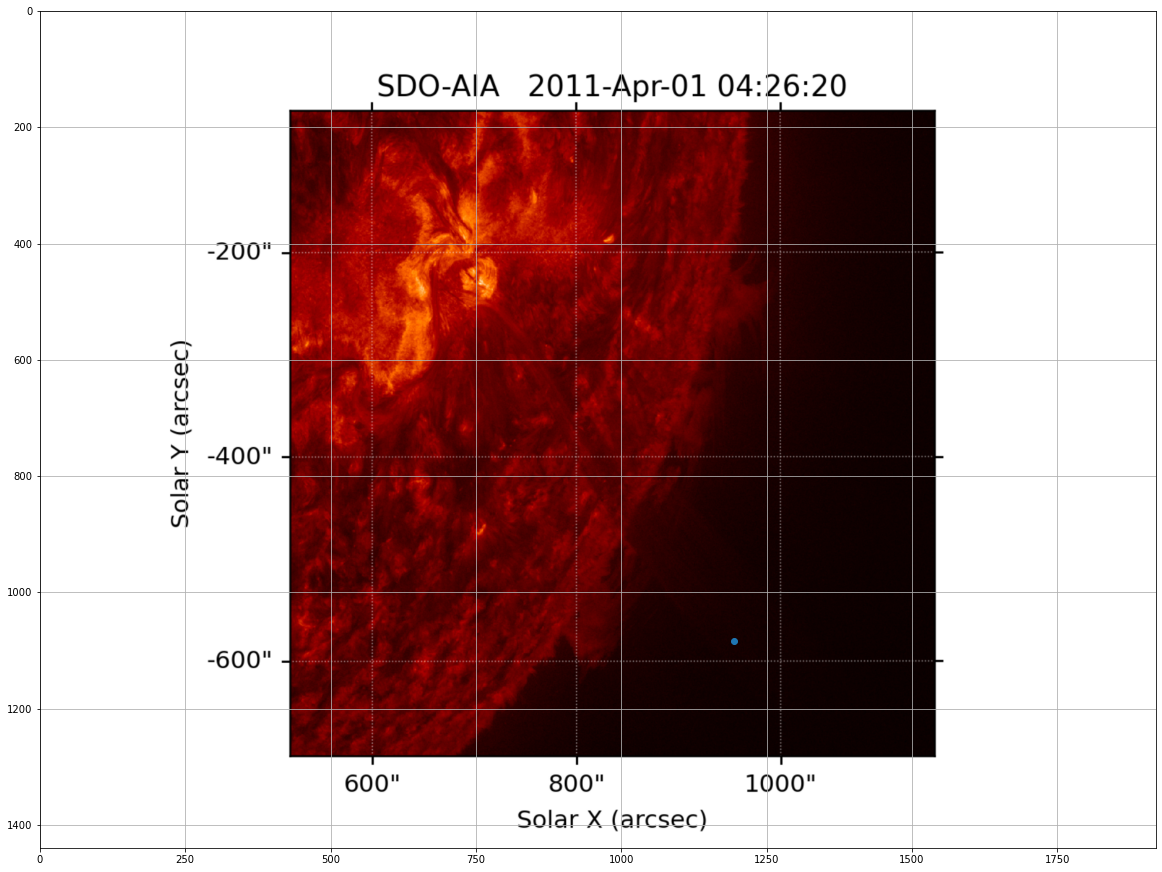

In [66]:
plt.figure(figsize=(20,20))
plt.imshow(get_subject_image(Jbad.subject))
plt.scatter(1193.67837261, 1083.46653077)
plt.grid()

### Go through the list of jet clusters and determine their propeties in physical coordinates

In [6]:
ID=1

for C in Jet_clusters:
    print('Jet start')
    H=np.array([])
    W=np.array([])
    X=np.array([])
    Y=np.array([])
    sig=np.array([])
    H_sig=np.zeros((len(C.jets),2))
    obs_time=np.array([],dtype='datetime64')
    end_time=np.array([],dtype='datetime64')
    for j, jet in enumerate(C.jets):
        #print(j, len(C.jets))
        width_pair,height_pair=jet.get_width_height_pairs()
        #Find sigma of maximum height by first getting the pixel height
        H_pix_box=np.sqrt((height_pair[1][0]-height_pair[0][0])**2 +(height_pair[1][1]-height_pair[0][1])**2 )
        index=list(map(int, jet.cluster_values)).index(int(H_pix_box))
        #Get the height of the box in pixels for the +-1 sigma
        plus_sigma, minus_sigma = sigma_shape(jet.cluster_values, jet.sigma)
        H_pix_minus= minus_sigma[index]
        H_pix_plus= plus_sigma[index]
        #print(width_pair,height_pair)
        file=subject_file[subjects==jet.subject][0]
        #Get the solar locations on the jet
        Bx,By=solar_conversion(file,jet.start[0],jet.start[1])
        Ex,Ey=solar_conversion(file,jet.end[0],jet.end[1])
        print('Start base',Bx,By)
        print('sigma',jet.sigma)
        #Add as attributes and as a list
        jet.adding_new_attr("solar_start",[Bx,By])
        jet.adding_new_attr("solar_end",[Ex,Ey])
        sig=np.append(sig,jet.sigma)
        X=np.append(X,Bx)
        Y=np.append(Y,By)
        #Get the dates the subjecst were observed
        O=date[subjects==jet.subject][0]
        obs_time=np.append(obs_time,O)
        E=end_date[subjects==jet.subject][0]
        end_time=np.append(end_time,E)
        #Calculate the height an wisth in arcsec
        height=get_solar_distance(file,height_pair)
        width=get_solar_distance(file,width_pair)
        #Add as attributes and list
        jet.adding_new_attr("solar_H",height)
        jet.adding_new_attr("solar_W",width)
        H=np.append(H,height)
        W=np.append(W,width)
        #Get the error on the height by scaling the height with the (height_sigma/height -1)
        err_plus, err_minus = height*(H_pix_plus/H_pix_box-1) , height*(H_pix_minus/H_pix_box-1)
        H_sig[j]=np.array([err_plus,err_minus])
        jet.adding_new_attr("solar_H_sig",[err_plus,err_minus])
    
    #duration=(obs_time[-1]-obs_time[0])/np.timedelta64(1, 'm')
    duration=(end_time[-1]-obs_time[0])/np.timedelta64(1, 'm')
    vel=np.max(H)/((obs_time[np.argmax(H)]-obs_time[0])/ np.timedelta64(1, 's'))
    if np.isinf(vel)==True:
        vel=np.NaN
    
    C.adding_new_attr("ID",ID)
    C.adding_new_attr('Max_Height', np.max(H))
    C.adding_new_attr('std_maxH', H_sig[np.argmax(H)])
    C.adding_new_attr("Height",np.average(H))
    C.adding_new_attr("std_H",np.std(H))
    C.adding_new_attr("Width",np.average(W))
    C.adding_new_attr("std_W",np.std(W))
    C.adding_new_attr("Bx",np.average(X))
    C.adding_new_attr("std_Bx",np.std(X))
    C.adding_new_attr("By",np.average(Y))
    C.adding_new_attr("std_By",np.std(Y))
    C.adding_new_attr("obs_time",obs_time[0])
    C.adding_new_attr("sigma",np.average(sig))
    C.adding_new_attr("Duration",duration)
    C.adding_new_attr("Velocity",vel)
    C.adding_new_attr("flag",'222')#temporary flag
    
    ID+=1

    


Jet start


Start base 244.15 -206.137
sigma 0.43298044242893924


Start base 252.03 -280.261
sigma 0.7331655692446822


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 693.845 -235.259
sigma 0.5390327160341887


Start base 699.828 -232.312
sigma 0.507768237700927


Start base 694.605 -229.875
sigma 0.5895806255367835


Start base 702.732 -240.781
sigma 0.5875513033749801


Start base 751.07 -270.65
sigma 0.5808681471196694


Start base 780.597 -294.93
sigma 0.5875480895341281


Start base 843.291 -328.332
sigma 0.47166342897701063


Jet start
Start base -604.739 232.022
sigma 0.5510380746108533


Start base -652.701 280.663
sigma 0.6225420397475263


Start base -663.496 267.506
sigma 0.5868238833639122


Jet start
Start base -276.22 -208.779
sigma 0.43638572497574707


Start base -275.525 -211.621
sigma 0.4052343912942883


Jet start
Start base -344.701 -308.237
sigma 0.5495657770458087


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -310.201 -298.181
sigma 0.5606185743888634


Start base -303.039 -265.027
sigma 0.48351805951672894


Jet start
Start base -298.496 -302.449
sigma 0.5466001400579921


Start base -290.173 -299.516
sigma 0.6051947469412743


Jet start
Start base -262.38 -305.376
sigma 0.5860631466895073


Start base -252.087 -298.379
sigma 0.5756737986058765


Start base -251.361 -297.726
sigma 0.5543290973359764


Jet start
Start base -249.324 -299.085
sigma 0.6268711155103701


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base -244.971 -300.142
sigma 0.4473516046758538


Start base -248.263 -301.188
sigma 0.6352260624883512


Jet start
Start base -239.222 -398.132
sigma 0.5655182908628646


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -242.871 -300.519
sigma 0.5544423258301977


Start base -242.756 -302.731
sigma 0.4988842102691123


Jet start
Start base -235.57 -298.557
sigma 0.6690834275394227


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -272.775 -366.002
sigma 0.6983854774343546


Start base -215.405 -297.567
sigma 0.5903759787461436


Jet start
Start base -235.236 -953.295
sigma 0.657060187586339


Start base -234.793 -949.794
sigma 0.4151303210306507


Start base -232.677 -947.271
sigma 0.49977937464637573


Start base -221.77 -951.792
sigma 0.480673281179306


Start base -216.237 -947.12
sigma 0.4383781827234347


Start base -215.555 -973.281
sigma 0.49881865851284685


Start base -226.115 -966.366
sigma 0.36073966375273503


Start base -230.235 -966.794
sigma 0.4255809645116537


Jet start
Start base -144.75 383.548
sigma 0.6611035179615712


Start base -142.5 389.26
sigma 0.5092567126751046


Jet start
Start base -142.5 389.26
sigma 0.44914089162537685


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -100.466 387.028
sigma 0.662316985947212


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -11.371 475.01
sigma 0.3419425868311296


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -61.2733 374.005
sigma 0.6446767376446741


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -26.5456 371.773
sigma 0.6762462602214488


Start base -62.926 415.26
sigma 0.7727147161933025


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 189.496 971.947
sigma 0.5148074610184884


Start base 192.934 975.256
sigma 0.6066771269072393


Start base 225.991 963.137
sigma 0.2965294508044583


Start base 232.902 960.865
sigma 0.5254020929175413


Start base 213.699 970.893
sigma 0.47724337807478123


Start base 237.409 962.43
sigma 0.5362469992344514


Start base 246.661 963.756
sigma 0.6919749678473924


Start base -7.96181 994.367
sigma 0.3200097932051216


Start base -7.22323 988.99
sigma 0.6278101142741406


Start base 16.4876 977.961
sigma 0.21505651306984508


Start base 16.7876 976.183
sigma 0.42999348564553325


Jet start
Start base 69.4216 982.994
sigma 0.31183791381443904


Start base -4.9731 992.3
sigma 0.3076753357759946


Jet start


Start base 16.4876 977.961
sigma 0.374407179017736


Start base 14.3815 992.352
sigma 0.6156534428807631


Jet start
Start base 42.8337 984.985
sigma 0.46302893483529656


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 211.526 967.483
sigma 0.5593583699863819


Start base 209.354 965.621
sigma 0.6336724759212529


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 624.916 759.58
sigma 0.5892536380485963


Start base 599.651 776.841
sigma 0.32520171439593243


Start base 597.006 783.73
sigma 0.38889761496809166


Start base 601.182 788.565
sigma 0.343329955185699


Start base 601.352 788.548
sigma 0.3917335446976558


Start base 593.994 792.887
sigma 0.34530415791152347


Start base 606.348 781.841
sigma 0.41357632791005206


Start base 633.192 753.011
sigma 0.62528215902479


Start base 556.009 820.441
sigma 0.29211562483387027


Jet start
Start base 624.916 759.58
sigma 0.25216765884888565


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 556.009 820.441
sigma 0.5329945494588999


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 556.009 820.441
sigma 0.3651439198821835


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 590.438 795.556
sigma 0.6175428481020712


Start base 589.89 794.223
sigma 0.3905298214734206


Jet start
Start base 852.927 491.796
sigma 0.40995395442261306


Start base 852.666 489.027
sigma 0.5971704535347445


Start base 854.818 491.301
sigma 0.5044060545722893


Start base 850.897 490.412
sigma 0.5440818344598165


Start base 851.073 492.605
sigma 0.5432498543565549


Start base 853.165 489.781
sigma 0.5257186225701094


Start base 860.71 490.907
sigma 0.43250470142543


Jet start
Start base -852.557 485.88
sigma 0.5614853417581581


Start base -824.997 474.367
sigma 0.40178851545815236


Start base -831.665 469.698
sigma 0.49824740584627647


Start base -831.247 466.567
sigma 0.4303259471390733


Start base -865.718 454.521
sigma 0.39992642639721554


Start base -859.828 455.282
sigma 0.42624990267226703


Start base -869.214 453.07
sigma 0.4251871511317758


Start base -837.236 458.729
sigma 0.4158111417771438


Start base -855.981 480.911
sigma 0.5914244838373237


Jet start
Start base -855.981 480.911
sigma 0.4356741152813834


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -74.4699 890.068
sigma 0.6361593364626317


Start base -73.3118 894.223
sigma 0.5899721969452356


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -623.887 119.079
sigma 0.5098752980165954


Start base -737.637 92.5524
sigma 0.5318587406022539


Start base -671.623 56.3262
sigma 0.7975612522460189


Start base -649.233 157.784
sigma 0.6717714598869526


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -657.394 41.8297
sigma 0.6191217969340482


Start base -676.031 65.7437
sigma 0.4589413680374702


Start base -645.325 55.4427
sigma 0.5767085195114339


Start base -656.837 60.0567
sigma 0.43333490394381025


Start base -669.196 60.3909
sigma 0.41038556466865134


Start base -654.343 49.7744
sigma 0.496515037149174


Start base -668.431 47.5641
sigma 0.4418387611889155


Start base -659.617 45.6881
sigma 0.4986359328986549


Start base -662.536 49.9029
sigma 0.6428748703475535


Start base -662.917 63.7469
sigma 0.6091481451511798


Start base -657.418 56.8974
sigma 0.5006643710168506


Start base -658.619 48.5335
sigma 0.546753815779167


Start base -651.07 55.1974
sigma 0.5239521840138588


Start base -651.702 61.1671
sigma 0.5029306041139058


Start base -657.879 63.0541
sigma 0.49309685511483065


Start base -756.051 137.844
sigma 0.4707570466339639


Start base -661.661 75.9527
sigma 0.42862019233114257


Start base -648.566 114.253
sigma 0.6295281688677229


Jet start
Start base -658.619 48.5335
sigma 0.4166372480587924


Start base -651.702 61.1671
sigma 0.49932029760641544


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -917.894 260.183
sigma 0.5973979058633443


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -921.456 248.457
sigma 0.3803202783826379


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -921.456 248.457
sigma 0.515560548344529


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -914.742 265.446
sigma 0.7220037922253382


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -917.0 248.901
sigma 0.5571379562406236


Start base -915.428 258.824
sigma 0.633554057866687


Start base -918.011 259.341
sigma 0.5099955458049156


Start base -926.24 238.121
sigma 0.6718403276009377


Jet start
Start base -911.893 309.539
sigma 0.29415006212241024


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -917.123 255.349
sigma 0.632901055047107


Start base -921.72 245.363
sigma 0.655348560776005


Start base -920.413 246.487
sigma 0.6325299916773288


Start base -922.938 245.316
sigma 0.6348302569530705


Start base -922.76 248.465
sigma 0.6103929822834927


Start base -921.171 246.355
sigma 0.5030213395371947


Start base -915.475 258.307
sigma 0.33524208543877304


Start base -914.597 257.207
sigma 0.5303355283686798


Start base -916.991 256.32
sigma 0.6056354510246883


Jet start
Start base -916.991 256.32
sigma 0.49142897685949594


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -915.697 258.714
sigma 0.5379425591564716


Start base -916.726 258.854
sigma 0.562103196448898


Start base -918.224 259.063
sigma 0.5509156755000141


Start base -915.812 262.352
sigma 0.5833566647302865


Start base -915.355 258.478
sigma 0.3752927545373348


Start base -916.783 260.656
sigma 0.6018808782788355


Start base -923.315 245.603
sigma 0.6401235305748367


Start base -914.76 256.417
sigma 0.5210840150936242


Start base -915.16 262.552
sigma 0.5080406142582027


Start base -921.688 251.712
sigma 0.5404678610606585


Start base -921.031 255.458
sigma 0.695395531141434


Start base -917.08 258.461
sigma 0.49820129170792965


Start base -914.152 264.156
sigma 0.4484652181297686


Start base -914.531 264.834
sigma 0.5175762606802872


Start base -916.172 258.559
sigma 0.46425592903711493


Start base -915.311 260.785
sigma 0.48960896073114435


Start base -916.382 261.677
sigma 0.4043750216820213


Start base -915.622 259.849
sigma 0.48256749764625817


Start base -918.542 260.775
sigma 0.721540618025401


Start base -921.362 253.706
sigma 0.5795858185718566


Start base -918.876 255.688
sigma 0.59915038348894


Start base -917.951 254.605
sigma 0.7381233325598422


Start base -915.071 261.137
sigma 0.5536143434511199


Start base -916.325 262.59
sigma 0.5148818443233109


Start base -913.85 267.863
sigma 0.617842846963077


Start base -911.39 272.369
sigma 0.4423144628255778


Start base -912.292 269.058
sigma 0.7214939055125512


Start base -913.301 268.596
sigma 0.4824895725203321


Start base -917.205 263.441
sigma 0.5153781586141867


Start base -913.979 270.605
sigma 0.5386071360242416


Start base -918.618 257.088
sigma 0.5782443886442341


Start base -916.384 259.826
sigma 0.7411680428312087


Jet start
Start base -921.688 251.712
sigma 0.5465596530035953


Start base -926.609 237.817
sigma 0.6057142600868534


Start base -914.797 316.651
sigma 0.7118095239573718


Start base -903.692 299.923
sigma 0.6337678305275939


Start base -899.723 307.136
sigma 0.6619765070180523


Jet start
Start base -918.542 260.775
sigma 0.48554322521167176


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -912.292 269.058
sigma 0.5174316152588704


Start base -923.506 259.834
sigma 0.3003187668536341


Start base -917.205 263.441
sigma 0.5880398656757423


Jet start
Start base -908.148 278.302
sigma 0.7064619988769569


Start base -908.992 276.135
sigma 0.5871183016495385


Start base -901.6 311.596
sigma 0.7260243677066376


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -901.6 311.596
sigma 0.36334363298290173


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -754.639 315.743
sigma 0.5372297758644163


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -914.655 259.625
sigma 0.49172531541851244


Start base -912.952 270.568
sigma 0.6209151356805953


Start base -915.091 264.881
sigma 0.4879713123301206


Start base -916.483 267.505
sigma 0.5725356794976778


Start base -901.406 300.044
sigma 0.7643705143777688


Jet start
Start base -901.406 300.044
sigma 0.49543290293402986


Start base -869.172 365.146
sigma 0.36692425350722463


Jet start
Start base -913.683 267.12
sigma 0.4094547764067553


Start base -915.909 264.472
sigma 0.5234477108063855


Start base -914.851 266.13
sigma 0.4424172570462507


Start base -916.336 268.455
sigma 0.51830234102364


Start base -917.676 266.673
sigma 0.5247654422497581


Start base -915.711 268.115
sigma 0.36139686506114604


Jet start
Start base -917.522 249.319
sigma 0.4000010307734276


Start base -904.349 281.622
sigma 0.6800745461702091


Start base -914.164 262.917
sigma 0.4600900955023601


Start base -917.161 258.996
sigma 0.5350497434632085


Start base -912.424 266.256
sigma 0.33629146564303136


Start base -913.194 269.389
sigma 0.4864360557303368


Start base -924.031 234.842
sigma 0.6565986158540005


Start base -916.555 254.71
sigma 0.7156817166780457


Jet start


Start base -904.349 281.622
sigma 0.52777234281865


Start base -783.26 300.599
sigma 0.46016017735305487


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -890.861 328.4
sigma 0.5110671544166103


Start base -903.953 296.364
sigma 0.5940865046075472


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -924.031 234.842
sigma 0.5618048812460438


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -910.941 263.291
sigma 0.5430618884822215


Start base -918.318 259.22
sigma 0.6227387120317318


Start base -915.374 264.3
sigma 0.454554937839562


Start base -913.865 262.62
sigma 0.5864037217290078


Start base -913.004 269.998
sigma 0.5296143028306755


Start base -912.74 270.33
sigma 0.44550432670158957


Start base -911.661 270.828
sigma 0.45862970209095105


Start base -912.142 272.79
sigma 0.5334256846888497


Start base -916.603 258.173
sigma 0.5682343937153531


Start base -912.932 269.283
sigma 0.5897625018478478


Start base -913.465 265.139
sigma 0.5918229438676862


Start base -911.993 268.156
sigma 0.5802323468650971


Start base -921.721 259.899
sigma 0.5400464321810367


Start base -913.592 268.548
sigma 0.518072963189142


Start base -912.163 270.256
sigma 0.4639984777572106


Start base -929.771 239.839
sigma 0.42071794309156424


Start base -921.451 239.168
sigma 0.4069378107489762


Start base -912.846 266.358
sigma 0.6957717858278604


Start base -919.519 248.331
sigma 0.5314442583790686


Jet start
Start base -906.664 294.379
sigma 0.5495688789102642


Start base -915.374 264.3
sigma 0.5667677363374664


Jet start
Start base -922.647 235.765
sigma 0.5651527866724473


Start base -922.839 231.496
sigma 0.17692586295606363


Jet start
Start base -922.839 231.496
sigma 0.5812869435658269


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -731.342 254.862
sigma 0.5559139941528435


Start base -733.089 259.18
sigma 0.3538851748067106


Jet start
Start base -912.163 270.256
sigma 0.3764743507172837


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -912.95 265.048
sigma 0.57792101580637


Start base -919.329 258.473
sigma 0.48338500372330495


Start base -916.255 265.685
sigma 0.4820271474996875


Jet start
Start base -914.623 261.562
sigma 0.485923285630679


Start base -916.241 256.566
sigma 0.6540516458887193


Start base -921.111 253.43
sigma 0.5960199701326327


Start base -912.599 263.749
sigma 0.6872435018505249


Start base -919.71 251.844
sigma 0.6097903477537767


Start base -915.34 259.429
sigma 0.5050165364383427


Start base -915.446 264.876
sigma 0.5459588571557548


Start base -915.492 261.759
sigma 0.5518395858463354


Start base -916.445 259.606
sigma 0.5255670077789997


Start base -918.19 258.863
sigma 0.47968712970292626


Start base -917.882 262.861
sigma 0.5682890142097732


Start base -921.941 256.187
sigma 0.5287330759211488


Start base -916.084 262.911
sigma 0.5489075944499016


Start base -913.97 266.027
sigma 0.5288003796947528


Jet start
Start base -925.128 226.358
sigma 0.3479725815432174


Start base -901.286 303.885
sigma 0.46018082169837654


Start base -915.537 292.335
sigma 0.5265714041945354


Jet start
Start base -901.242 304.986
sigma 0.6452395540040156


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -901.242 304.986
sigma 0.25565555707092796


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -905.806 289.853
sigma 0.5217037794547992


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -900.529 302.036
sigma 0.4059802132896287


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -923.103 250.629
sigma 0.3768087124025338


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -917.388 258.947
sigma 0.5580664192490938


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 832.799 -223.603
sigma 0.5355961193444115


Start base 833.532 -222.331
sigma 0.5696519329609309


Jet start
Start base 831.454 -225.881
sigma 0.664217314244567


Start base 831.57 -225.89
sigma 0.5014351573660091


Start base 834.187 -224.837
sigma 0.5435066834008114


Start base 835.63 -224.543
sigma 0.5105299307080506


Start base 835.338 -224.328
sigma 0.44334023519462473


Jet start
Start base 803.685 -256.667
sigma 0.41323234501544504


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 809.431 -235.576
sigma 0.4024621120002142


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 830.18 -231.325
sigma 0.1681526190754202


Start base 829.8 -229.735
sigma 0.7051491221877623


Start base 830.363 -230.092
sigma 0.4640275957709518


Start base 832.086 -225.639
sigma 0.6072245007382164


Jet start
Start base 837.626 -230.266
sigma 0.4678087637100735


Start base 841.141 -225.94
sigma 0.6103522131990275


Start base 840.8 -227.24
sigma 0.530339123767091


Start base 843.142 -227.06
sigma 0.5382895231445967


Start base 840.867 -228.171
sigma 0.6292402394779113


Start base 843.789 -227.921
sigma 0.4449035045711514


Start base 848.84 -224.567
sigma 0.6794069800092749


Jet start
Start base -414.83 430.489
sigma 0.47357000306717634


Start base -409.972 427.543
sigma 0.6316828907909989


Start base -409.627 426.377
sigma 0.5527974359851315


Jet start
Start base -49.5684 590.319
sigma 0.3747216673287791


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -50.4411 594.005
sigma 0.46760961798845546


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -236.418 142.247
sigma 0.49783803488997025


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 539.282 37.1575
sigma 0.5327654946070997


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 475.608 75.3184
sigma 0.5468247713452209


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -537.006 210.235
sigma 0.5031953082020546


Start base -544.976 206.993
sigma 0.6175386739315689


Start base -544.331 207.968
sigma 0.4750647910592189


Start base -545.374 209.15
sigma 0.5303802977725414


Jet start
Start base -545.197 211.709
sigma 0.5495541676670123


Start base -541.068 210.26
sigma 0.5612274678228812


Start base -548.334 217.272
sigma 0.38282550621874056


Start base -542.994 213.299
sigma 0.6636443182046382


Jet start
Start base -527.043 204.931
sigma 0.4886676974128285


Start base -542.62 218.261
sigma 0.3999393321776771


Start base -528.576 213.278
sigma 0.6392493459258695


Jet start
Start base -559.963 216.49
sigma 0.5831642790927651


Start base -478.83 179.508
sigma 0.6290881067103331


Jet start
Start base -526.218 215.267
sigma 0.5761321460681847


Start base -522.67 213.678
sigma 0.5736131965881094


Jet start
Start base -469.001 235.304
sigma 0.6541319417672672


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -525.58 217.934
sigma 0.7334502511179927


Start base -512.812 208.8
sigma 0.5767006070920936


Jet start
Start base -517.109 216.877
sigma 0.6056174115495775


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -500.209 213.188
sigma 0.43163613668109274


Start base -493.449 208.918
sigma 0.46835857913876233


Start base -510.989 215.693
sigma 0.40822825525373513


Jet start
Start base -652.516 303.66
sigma 0.5305818806852426


Start base -655.103 305.378
sigma 0.4799946365457906


Jet start
Start base -810.429 448.905
sigma 0.6951692942561521


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base -679.42 282.768
sigma 0.45282393414825


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 746.155 308.768
sigma 0.33514264116818443


Start base 779.823 306.745
sigma 0.11194428840678625


Start base 790.659 311.272
sigma 0.730638858848455


Jet start
Start base 779.823 306.745
sigma 0.49272460044389355


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 544.831 -802.307
sigma 0.38417912150044736


Start base 543.479 -805.362
sigma 0.5030725515980652


Start base 540.634 -805.471
sigma 0.4464649733582408


Start base 562.739 -793.425
sigma 0.48901294584233523


Start base 568.659 -794.284
sigma 0.5598869387019846


Jet start
Start base 477.304 -851.06
sigma 0.4293588430730873


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 597.386 -770.254
sigma 0.32392774247836587


Start base 598.323 -767.573
sigma 0.34753055331160493


Start base 605.573 -760.964
sigma 0.5884867945821084


Jet start
Start base 1597.18 64.7225
sigma 0.45641865722574126


Start base 1047.22 181.598
sigma 0.4460073282750197


Start base 1220.94 100.616
sigma 0.454405498756693


Jet start
Start base 1192.66 -69.186
sigma 0.5654386204252069


Start base 1092.82 3.05989
sigma 0.393685189578638


Start base 1182.99 -60.8947
sigma 0.31414790502442624


Start base 1221.0 -71.6856
sigma 0.5377273978251148


Start base 1265.49 -104.235
sigma 0.26872219696446364


Jet start
Start base 1188.69 124.837
sigma 0.46491906330379806


Start base 1250.19 131.004
sigma 0.5709535371385395


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 882.521 159.732
sigma 0.4484321563232639


Start base 887.107 151.845
sigma 0.5113571908623723


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 912.247 83.1297
sigma 0.4968359800357906


Start base 911.491 105.609
sigma 0.5008685551423839


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 907.605 121.673
sigma 0.5081901112490244


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 414.31 -277.86
sigma 0.6371906959333021


Start base 462.332 -276.046
sigma 0.7023069925229676


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 290468.0 -12249.7
sigma 0.5260262360225433


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 626.866 117.858
sigma 0.6694663212467068


Start base 601.094 275.15
sigma 0.5755043000686901


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 687.147 240.891
sigma 0.548646977210991


Start base 712.477 222.097
sigma 0.19956883760167704


Jet start
Start base 614.218 278.003
sigma 0.5891504751262648


Start base 677.304 246.635
sigma 0.3845004336966567


Start base 646.291 296.072
sigma 0.5353305496403322


Start base 631.54 210.872
sigma 0.4974252825705387


Jet start
Start base 636.424 73.2601
sigma 0.6235529450862027


Start base 527.982 310.526
sigma 0.426247846347247


Start base 446.728 361.826
sigma 0.5161140209101089


Start base 516.938 363.956
sigma 0.4568235343742402


Jet start
Start base 566.245 301.529
sigma 0.5940791658868915


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -598.171 -328.328
sigma 0.41402132364469113


Start base -591.547 -331.365
sigma 0.48902671198352893


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -589.766 -299.75
sigma 0.6031944985787796


Start base -607.876 -275.797
sigma 0.40867597964150465


Jet start
Start base -673.255 -323.745
sigma 0.5176046472211748


Start base -597.658 -313.866
sigma 0.5897401296340207


Jet start
Start base -585.13 -297.311
sigma 0.5589693328511774


Start base -591.292 -294.771
sigma 0.5852024715744301


Start base -555.749 -306.518
sigma 0.585700564545009


Start base -555.349 -305.741
sigma 0.43493658405359303


Start base -551.073 -309.057
sigma 0.6304460591198789


Jet start
Start base -582.927 -327.554
sigma 0.3203493776813749


Start base -583.752 -327.844
sigma 0.24009922649310667


Jet start
Start base -594.934 -320.101
sigma 0.3693634205524691


Start base -596.979 -323.714
sigma 0.5456618413851957


Jet start
Start base -498.137 -317.813
sigma 0.30047247474394684


Start base -505.98 -323.036
sigma 0.5938436423734653


Start base -501.212 -324.797
sigma 0.5034685177458923


Start base -527.676 -290.59
sigma 0.6151492237145074


Start base -522.305 -295.125
sigma 0.6915949135624201


Start base -497.119 -308.383
sigma 0.5749633315654287


Jet start
Start base -526.476 -293.196
sigma 0.6082360893187195


Start base -501.212 -324.797
sigma 0.4379775837442016


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -576.654 -293.897
sigma 0.38842229360436653


Start base -487.291 -296.458
sigma 0.4875298581319569


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -418.37 -279.37
sigma 0.4899135123947071


Start base -419.365 -285.515
sigma 0.5023585802078365


Start base -411.119 -287.203
sigma 0.5934482093453828


Start base -425.303 -299.985
sigma 0.6221421796395319


Jet start


Start base -471.388 -313.601
sigma 0.4004232799185909


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -418.909 -259.859
sigma 0.5386120397951375


Start base -417.715 -269.828
sigma 0.581504148686864


Start base -407.681 -276.1
sigma 0.5335622612492593


Start base -437.301 -287.441
sigma 0.4395653349457265


Start base -448.647 -291.735
sigma 0.35471943587507093


Start base -419.005 -300.432
sigma 0.5592884298130832


Start base -423.662 -300.032
sigma 0.6173645817498861


Start base -420.736 -300.992
sigma 0.5793093490253627


Jet start
Start base -872.635 -376.534
sigma 0.4810611851076893


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -838.127 -403.537
sigma 0.6366404556764085


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -822.07 323.132
sigma 0.42002564077222765


Start base -805.146 338.017
sigma 0.4589059732841949


Start base -792.699 345.844
sigma 0.5548150774425697


Start base -836.752 284.53
sigma 0.46051613167201894


Jet start
Start base -666.721 328.627
sigma 0.5224548802020125


Start base -662.093 331.06
sigma 0.4995204594456695


Jet start
Start base -602.477 353.885
sigma 0.42897157985508094


Start base -639.198 360.37
sigma 0.45763686504473045


Start base -624.855 359.742
sigma 0.4043375544088796


Jet start
Start base 1237.89 271.545
sigma 0.5665731321211382


Start base 1233.26 277.522
sigma 0.5153523044014623


Start base 1239.07 268.326
sigma 0.531395089483477


Start base 1194.29 309.097
sigma 0.5474789829554044


Start base 1238.42 290.706
sigma 0.530149631354958


Jet start
Start base 235.063 -956.907
sigma 0.48127761973867444


Start base 213.204 -956.472
sigma 0.5056170982400646


Start base 226.263 -950.689
sigma 0.43196067190814363


Start base 217.102 -951.932
sigma 0.5300630914388395


Jet start
Start base 213.204 -956.472
sigma 0.4371019070680212


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 266.596 -939.761
sigma 0.5555569574153654


Start base 225.885 -954.547
sigma 0.629035083637642


Jet start
Start base 205.725 -954.798
sigma 0.5560605242464296


Start base 204.6 -959.741
sigma 0.4664921114577371


Start base 232.52 -948.512
sigma 0.5226560966239346


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 237.417 -956.627
sigma 0.42094264173058016


Start base 225.788 -952.27
sigma 0.458123738371166


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base 233.89 -951.747
sigma 0.24389821370088133


Start base 233.406 -946.113
sigma 0.5244473778760762


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 925.112 205.803
sigma 0.554976775550461


Start base 933.861 203.181
sigma 0.3678582729741984


Jet start
Start base 967.096 49.2887
sigma 0.4070429248211034


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 943.13 186.316
sigma 0.504459905817858


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 965.102 96.7482
sigma 0.5218682112573266


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 965.102 96.7482
sigma 0.6060778424168078


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 922.863 159.342
sigma 0.692795550558435


Start base 935.632 203.081
sigma 0.5273273496887111


Start base 965.121 81.0475
sigma 0.4264380797486347


Jet start
Start base 965.121 81.0475
sigma 0.28099751847261883


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 967.057 76.6508
sigma 0.5158085266804456


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 967.057 76.6508
sigma 0.679517762766554


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 945.942 -22.0347
sigma 0.4562844806693502


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 944.512 185.296
sigma 0.47057594005552755


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 945.942 -22.0347
sigma 0.772571551111679


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 941.208 192.085
sigma 0.534601311226564


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 947.327 181.434
sigma 0.7450860285022103


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 949.225 180.35
sigma 0.5712911238201148


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 946.391 177.92
sigma 0.6170830710349752


Start base 948.06 176.445
sigma 0.5769651270728098


Start base 946.2 176.252
sigma 0.5894530644880341


Jet start
Start base 947.348 178.904
sigma 0.7590805548688846


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 951.016 174.262
sigma 0.6499117311213831


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 954.91 141.864
sigma 0.4781724070090152


Start base 956.331 146.917
sigma 0.5944954752748866


Jet start
Start base 954.91 141.864
sigma 0.5340946707840828


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 854.085 175.844
sigma 0.4962152998763213


Start base 858.743 172.126
sigma 0.5634719345998267


Jet start
Start base 947.22 194.354
sigma 0.5138410860167101


Start base 947.127 194.998
sigma 0.2643978756923094


Jet start
Start base 953.277 200.472
sigma 0.27575955886549414


Start base 957.139 -121.312
sigma 0.5886023023717046


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 953.277 200.472
sigma 0.6901504112067355


Start base 957.139 -121.312
sigma 0.3418565349348494


Jet start
Start base 957.139 -121.312
sigma 0.11168092245813863


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base 952.276 173.788
sigma 0.5143649375857867


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 964.156 -123.845
sigma 0.28829909120416125


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 964.156 -123.845
sigma 0.37711037955254717


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 948.25 187.475
sigma 0.6404620230587492


Start base 952.675 193.904
sigma 0.5514774851260507


Jet start
Start base 202.921 591.753
sigma 0.47044104553837623


Start base 207.507 570.437
sigma 0.34568936664559635


Start base 204.724 614.776
sigma 0.7291471840028981


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 202.921 591.753
sigma 0.29060492411687555


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 269.322 378.97
sigma 0.4882265103834794


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 208.018 612.564
sigma 0.6860632424523656


Start base 206.807 604.282
sigma 0.6349551792265852


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 214.004 603.707
sigma 0.3630454002533803


Start base 217.643 599.48
sigma 0.5622871975513593


Jet start
Start base -116.665 979.621
sigma 0.4969576833159877


Start base -113.833 980.857
sigma 0.523853491633694


Start base -105.403 984.806
sigma 0.46504986212956456


Jet start
Start base 99.6415 987.483
sigma 0.465272244066874


Start base 101.84 984.151
sigma 0.6013558475327039


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 317.244 936.376
sigma 0.5170046579651836


Start base 310.492 937.395
sigma 0.5250845993458372


Jet start
Start base 338.124 924.027
sigma 0.41206193878809166


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 244.671 839.633
sigma 0.5008804176341229


Start base 265.985 839.172
sigma 0.6002471370166941


Start base 268.118 835.653
sigma 0.5471026155818792


Jet start
Start base -689.39 668.867
sigma 0.4275493531630789


Start base -683.145 666.52
sigma 0.27199150201291106


Start base -680.556 672.895
sigma 0.4218300358118235


Start base -675.249 674.229
sigma 0.3838656718863158


Start base -678.461 670.854
sigma 0.42572653142860406


Jet start
Start base -154.835 -275.451
sigma 0.7095370185594002


Start base -155.085 -274.294
sigma 0.5749164090319464


Start base -153.357 -269.977
sigma 0.5275419384471938


Start base -151.73 -284.805
sigma 0.3539037701585883


Start base -149.788 -281.59
sigma 0.538434654928866


Start base -148.667 -281.244
sigma 0.5204924595444339


Start base -147.633 -275.751
sigma 0.4370916596977986


Start base -147.782 -274.98
sigma 0.5489805826598375


Start base -145.841 -281.23
sigma 0.4431964436133861


Start base -144.709 -280.745
sigma 0.3377383372551321


Jet start
Start base -129.812 -304.284
sigma 0.6871361623663761


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -142.176 -276.808
sigma 0.5732568940725153


Start base -139.713 -278.068
sigma 0.5096519596911181


Start base -141.08 -277.886
sigma 0.4674796584600265


Start base -139.841 -273.447
sigma 0.5722179459571173


Start base -139.278 -273.349
sigma 0.5422353849530692


Jet start
Start base -136.583 -280.308
sigma 0.534405548746443


Start base -132.816 -279.169
sigma 0.6277062134665717


Start base -131.835 -279.091
sigma 0.6299661629871665


Start base -131.779 -280.124
sigma 0.5291219922194628


Start base -131.048 -278.994
sigma 0.3043268163656198


Start base -132.872 -275.668
sigma 0.45253074742502775


Jet start
Start base -134.138 -282.167
sigma 0.5851215969447435


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -130.241 -275.265
sigma 0.538940939219861


Start base -127.749 -275.238
sigma 0.6682008866315943


Start base -120.03 -292.53
sigma 0.5557645054036775


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -125.353 -276.995
sigma 0.5505957416561451


Start base -124.28 -278.931
sigma 0.5104266357631028


Start base -120.051 -279.177
sigma 0.39303206481368896


Start base -122.224 -283.079
sigma 0.5171970093509035


Start base -121.344 -281.474
sigma 0.4480568445548847


Start base -119.585 -279.174
sigma 0.3772933749074585


Start base -119.943 -278.311
sigma 0.6464021048084944


Start base -109.274 -294.078
sigma 0.6736878618598806


Start base -117.607 -278.197
sigma 0.5654762391989246


Start base -116.039 -277.327
sigma 0.6545418715607217


Start base -116.026 -278.032
sigma 0.5608266661438011


Start base -113.46 -278.727
sigma 0.5614934963996108


Start base -114.584 -276.459
sigma 0.6200147546369308


Start base -113.208 -275.724
sigma 0.5755395527365504


Jet start
Start base -115.088 -295.138
sigma 0.22728299208763467


Start base -113.254 -292.082
sigma 0.3470943949099633


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -109.274 -294.078
sigma 0.34723933828156844


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 24.1452 -953.877
sigma 0.33890375487949387


Start base 26.2146 -961.436
sigma 0.428366475384129


Jet start
Start base -144.327 -954.765
sigma 0.6956573537820787


Start base -147.673 -948.957
sigma 0.3794631018339936


Jet start
Start base -236.748 -928.317
sigma 0.4531219133882038


Start base -233.374 -928.259
sigma 0.3842352463518646


Start base -234.602 -929.495
sigma 0.3563985423718852


Start base -236.441 -940.56
sigma 0.3286158335331899


Start base -233.068 -930.462
sigma 0.31285999270968856


Start base -228.136 -929.708
sigma 0.38249132926971835


Jet start
Start base -68.9073 -968.41
sigma 0.44547619869874044


Start base -68.2695 -956.5
sigma 0.38751375512121694


Start base -71.8889 -955.058
sigma 0.36730289731350596


Start base -77.5081 -955.345
sigma 0.3154906654249219


Start base -76.4283 -954.186
sigma 0.3544079514470118


Start base -68.7141 -953.123
sigma 0.6211077659770299


Jet start
Start base -218.771 -932.209
sigma 0.41638998592635124


Start base -215.743 -932.75
sigma 0.3668845375056235


Start base -221.253 -932.793
sigma 0.46105031958844855


Jet start


Start base -76.4283 -954.186
sigma 0.3867586558926382


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base

 -567.637 -479.118
sigma 0.6876839719622526


Start base -574.443 -508.47
sigma 0.5357665419734765


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base -953.026 -4.40995
sigma 0.6198416201247583


Start base -984.963 67.9642
sigma 0.3556669427108429


Jet start
Start base -945.63 281.658
sigma 0.3868782373353275


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -945.63 281.658
sigma 0.7174213879761908


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -963.199 213.917
sigma 0.5821600162363266


Start base -960.953 214.685
sigma 0.5724991661293576


Start base -959.05 223.415
sigma 0.6181510894333836


Start base -967.814 66.4428
sigma 0.5781149938521354


Jet start
Start base -959.05 223.415
sigma 0.5719350115384993


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -1004.23 -6.05026
sigma 0.4458591087468062


Start base -1042.21 14.0811
sigma 0.6797060955585452


Jet start
Start base -902.035 310.904
sigma 0.5237498971666855


Start base -939.477 298.956
sigma 0.42255655501633177


Start base -945.952 301.861
sigma 0.39863452465131277


Jet start
Start base -982.432 123.614
sigma 0.3973096997175962


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -982.432 123.614
sigma 0.5849693424387594


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start


Start base -961.982 211.906
sigma 0.5011545577689355


Start base -962.773 212.863
sigma 0.50038616762599


Start base -977.665 135.691
sigma 0.47449119156577463


Start base -978.389 126.353
sigma 0.5318162368344775


Jet start
Start base -934.347 -5.80549
sigma 0.49859427876446755


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -1021.35 -5.8309
sigma 0.33351959011758386


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -960.094 211.887
sigma 0.4755175135036779


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -971.357 181.635
sigma 0.49103102804841237


Start base -968.682 182.118
sigma 0.4301372241522027


Start base -974.392 178.221
sigma 0.5964589890541105


Jet start
Start base -971.317 186.544
sigma 0.38290299303990843


Start base -970.366 188.511
sigma 0.42074408699830856


Jet start
Start base -957.11 223.074
sigma 0.7208400984971


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -968.666 163.437
sigma 0.6331485644537634


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -965.893 181.849
sigma 0.4232334308924134


Start base -984.164 183.501
sigma 0.40496500864920426


Start base -966.795 185.618
sigma 0.33959240105664185


Start base -966.413 187.702
sigma 0.4262201474001934


Start base -968.476 187.968
sigma 0.43776889812944353


Start base -964.574 183.279
sigma 0.44043036439076755


Start base -967.69 183.883
sigma 0.38405208383987505


Start base -967.483 176.708
sigma 0.34887737934217355


Start base -967.521 177.179
sigma 0.5076179979547911


Start base -967.488 182.586
sigma 0.33117768441357875


Start base -970.642 181.695
sigma 0.5257373292047639


Start base -966.817 182.36
sigma 0.44547626371104576


Start base -975.611 155.067
sigma 0.4529369803681943


Start base -965.894 186.682
sigma 0.3005795780074782


Start base -965.226 183.132
sigma 0.29448026320040577


Start base -969.063 179.141
sigma 0.5921561052841148


Start base -970.872 167.949
sigma 0.5044508036325656


Start base -969.375 185.521
sigma 0.40990956862763517


Jet start
Start base -984.358 102.711
sigma 0.5379312978613401


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.921 193.441
sigma 0.359948884078303


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -975.611 155.067
sigma 0.2684397238326623


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -944.896 285.075
sigma 0.2355894381352746


Start base -945.131 271.131
sigma 0.4676132647495391


Jet start


Start base -966.847 194.018
sigma 0.47841695221195507


Start base -967.246 188.171
sigma 0.38913696424614047


Jet start
Start base -980.044 124.397
sigma 0.40002655554353417


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -960.325 187.91
sigma 0.4482573242294224


Start base -966.489 185.363
sigma 0.43823282880934167


Start base -969.546 186.517
sigma 0.46546056650848355


Start base -965.497 194.57
sigma 0.2975041574928735


Start base -959.681 208.154
sigma 0.7263006716859337


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -983.249 111.018
sigma 0.5968376844505942


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.917 141.824
sigma 0.49561543256464635


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -963.575 204.27
sigma 0.6343088309388295


Start base -962.077 205.328
sigma 0.5323844794373892


Start base -961.567 209.636
sigma 0.5020712371484679


Start base -970.3 213.568
sigma 0.3959563007798472


Start base -959.887 209.334
sigma 0.6150633780914336


Jet start
Start base -974.361 132.253
sigma 0.4591000953568131


Start base -968.904 167.725
sigma 0.5083419024486272


Jet start
Start base -971.077 161.622
sigma 0.6535826853211436


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -971.179 167.27
sigma 0.5052728667957399


Start base -973.198 165.19
sigma 0.529999593986266


Start base -969.064 168.251
sigma 0.4651730405481524


Start base -969.005 170.915
sigma 0.5301882921307038


Start base -968.038 192.213
sigma 0.6603872763234422


Jet start
Start base -965.361 211.032
sigma 0.6361609160281733


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -980.275 130.529
sigma 0.6128801299227654


Start base -980.673 135.418
sigma 0.4096996787356917


Start base -968.537 169.185
sigma 0.4512288500166877


Start base -968.814 175.935
sigma 0.5953318095919866


Jet start
Start base -963.466 203.765
sigma 0.6794273587166314


Start base -965.62 205.632
sigma 0.5277358956357391


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -968.814 175.935
sigma 0.42930247811847105


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -964.232 211.877
sigma 0.5319035745360512


Start base -964.38 211.297
sigma 0.5308167682391223


Start base -959.766 210.051
sigma 0.6334632409789064


Jet start
Start base -968.98 166.572
sigma 0.6114984936516313


Start base -968.043 170.104
sigma 0.541372933423835


Start base -965.343 175.149
sigma 0.5031790189119655


Start base -967.963 172.285
sigma 0.5958488026846618


Jet start
Start base -961.505 217.041
sigma 0.7114605394860117


Start base -961.112 214.508
sigma 0.5228779103432784


Jet start
Start base -968.907 166.415
sigma 0.5477806020599195


Start base -967.784 169.544
sigma 0.5084456296347983


Start base -964.836 165.918
sigma 0.632557538262127


Start base -968.574 169.969
sigma 0.6123079816369713


Start base -965.286 173.452
sigma 0.48812811996963323


Start base -968.342 169.378
sigma 0.5959911864466553


Start base -979.642 170.271
sigma 0.5583119467096277


Start base -978.523 147.972
sigma 0.6465953308354245


Start base -965.811 177.695
sigma 0.42275875208141384


Start base -972.307 175.812
sigma 0.45492470536092544


Jet start
Start base -961.152 207.094
sigma 0.45468027491896124


Start base -960.668 205.751
sigma 0.41697633625983616


Start base -962.02 208.673
sigma 0.4831111101024702


Start base -962.574 209.169
sigma 0.463182107631626


Jet start
Start base -971.129 153.517
sigma 0.4315531492090836


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -963.805 173.813
sigma 0.4453759372435296


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.413 157.513
sigma 0.6386895791802051


Start base -971.006 161.433
sigma 0.607969815361756


Start base -970.713 168.279
sigma 0.541023622913853


Start base -973.344 165.206
sigma 0.4720703008614506


Start base -968.847 175.548
sigma 0.45844385329546317


Start base -964.943 179.528
sigma 0.5115608110977137


Jet start
Start base -971.006 161.433
sigma 0.4745329165445109


Start base -970.713 168.279
sigma 0.24217663670331388


Jet start
Start base -970.713 168.279
sigma 0.5462122742879724


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -981.289 125.29
sigma 0.5076030091127666


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.141 162.159
sigma 0.550808501011514


Start base -971.961 167.614
sigma 0.567344349871454


Jet start
Start base -956.073 239.439
sigma 0.5199368117198238


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -967.507 182.213
sigma 0.4038007772071533


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -974.509 165.977
sigma 0.56177645417596


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -958.814 187.623
sigma 0.6674795313607322


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -968.451 173.2
sigma 0.6793155897538078


Start base -968.882 178.706
sigma 0.21286751233166515


Start base -973.426 147.354
sigma 0.5886785735441967


Start base -975.266 149.669
sigma 0.4063244465557559


Start base -971.064 170.402
sigma 0.5445464676195759


Start base -969.92 170.623
sigma 0.6870918181679311


Start base -971.609 175.988
sigma 0.48843148306960354


Start base -978.858 145.905
sigma 0.6622368458492527


Start base -971.609 175.607
sigma 0.5902746170363705


Start base -967.514 179.852
sigma 0.49075026220088813


Jet start
Start base -968.451 173.2
sigma 0.43814678257005835


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -957.643 239.848
sigma 0.46109641903043697


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -963.217 201.247
sigma 0.30998604147979364


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -971.609 175.988
sigma 0.4334858404200454


Start base -969.031 174.61
sigma 0.7530164574541266


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -972.317 157.232
sigma 0.4934116182027345


Start base -972.425 163.324
sigma 0.5114279294682939


Start base -978.455 125.282
sigma 0.4948807975376607


Jet start
Start base -972.317 157.232
sigma 0.46451396655560234


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -978.455 125.282
sigma 0.4744665972531595


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -957.154 231.181
sigma 0.4879796624278076


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -972.223 151.873
sigma 0.5467225028316779


Start base -978.892 153.285
sigma 0.6077098862309965


Start base -967.469 175.093
sigma 0.5204059453119453


Start base -967.058 179.219
sigma 0.39694250433402184


Start base -970.035 184.868
sigma 0.4365827073474165


Start base -968.887 177.299
sigma 0.3112557287020413


Start base -968.966 175.639
sigma 0.6756955671747354


Start base -966.295 180.31
sigma 0.5794560482921071


Start base -967.574 175.972
sigma 0.6710708401834482


Jet start
Start base -966.547 211.308
sigma 0.6424446360153253


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -966.7 177.806
sigma 0.6037634322584869


Start base -968.13 185.259
sigma 0.28237789617805176


Start base -966.235 182.001
sigma 0.4029366939884845


Jet start
Start base -964.466 195.118
sigma 0.6095648135607175


Start base -966.327 199.147
sigma 0.4994403963848088


Start base -966.235 182.001
sigma 0.5309793261394526


Jet start


Start base -965.912 195.492
sigma 0.5156052674482213


Start base -964.713 196.937
sigma 0.5291075942056709


Jet start


Start base -979.103 162.843
sigma 0.3115805604831359


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -967.178 182.964
sigma 0.7197306397451972


Start base -965.805 185.675
sigma 0.6742266685446554


Jet start
Start base -967.178 182.964
sigma 0.5079428991519946


Start base -973.719 163.311
sigma 0.3303768558162805


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -966.9 180.08
sigma 0.42970390626263055


Start base -970.398 181.559
sigma 0.612900922159518


Start base -968.413 179.72
sigma 0.6052266592517553


Start base -966.495 182.54
sigma 0.6330036802143232


Start base -966.24 188.83
sigma 0.4454063396341288


Start base -974.304 189.515
sigma 0.4814175123460852


Start base -967.787 187.814
sigma 0.75472929319509


Start base -966.159 180.748
sigma 0.5900839630941943


Jet start
Start base -948.181 268.493
sigma 0.26241741946957675


Start base -955.354 237.622
sigma 0.39926901065372256


Jet start
Start base -964.431 182.885
sigma 0.572946772355699


Start base -968.517 174.538
sigma 0.6678558283471527


Start base -965.155 188.243
sigma 0.713917096383541


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -965.155 188.243
sigma 0.5208736199944756


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -966.697 186.044
sigma 0.4352437417033252


Start base -972.587 187.503
sigma 0.6139483480336915


Start base -967.023 190.452
sigma 0.5863504053596361


Start base -966.717 195.178
sigma 0.4740051068871843


Start base -965.487 193.491
sigma 0.48818744037939604


Start base -967.677 180.443
sigma 0.6253877103210126


Start base -967.698 179.91
sigma 0.4861528108144643


Jet start
Start base -971.358 174.727
sigma 0.42069663549779396


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -981.952 187.782
sigma 0.5090658106588735


Start base -970.271 185.379
sigma 0.41875077666983634


Start base -969.42 182.79
sigma 0.631663374816015


Start base -954.895 219.163
sigma 0.4356410985241097


Jet start
Start base -965.877 202.032
sigma 0.37897068184765864


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -967.996 188.836
sigma 0.596418636231054


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -963.189 195.16
sigma 0.4327621670100277


Start base -963.976 197.128
sigma 0.43740798448953433


Start base -963.437 197.687
sigma 0.4842915781548166


Start base -962.375 194.684
sigma 0.3594044027811249


Jet start


Start base -964.401 174.579
sigma 0.7378616114838612


Start base -967.52 175.047
sigma 0.4774239858262064


Start base -966.635 176.512
sigma 0.6105535968811691


Start base -966.261 182.644
sigma 0.6764115627116328


Jet start
Start base -963.004 198.128
sigma 0.6781714461639666


Start base -967.164 183.025
sigma 0.6603979976609291


Start base -965.8 197.367
sigma 0.6626592985052179


Start base -964.793 176.399
sigma 0.5407389362140433


Start base -963.504 197.865
sigma 0.6459760685283391


Start base -969.527 183.528
sigma 0.5925155655251734


Start base -965.811 191.339
sigma 0.6553222547818415


Start base -966.339 200.47
sigma 0.5201598645459825


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -967.904 180.92
sigma 0.5043715755451633


Start base -967.164 183.025
sigma 0.15559344406572878


Start base -987.909 168.724
sigma 0.27910025433445323


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -967.164 183.025
sigma 0.6088652717120724


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -965.811 191.339
sigma 0.7405248076040617


Start base -975.046 145.289
sigma 0.3889411641201517


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.152 201.918
sigma 0.6708923688483269


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -973.152 201.918
sigma 0.5672831222230248


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -965.114 183.682
sigma 0.52296667868142


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -961.263 239.443
sigma 0.4467737445565737


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -850.833 444.605
sigma 0.6137661204416246


Start base -859.624 440.993
sigma 0.5960847888180211


Start base -860.739 437.512
sigma 0.46469598498989106


Start base -860.766 431.765
sigma 0.5413196640013396


Start base -851.337 450.713
sigma 0.5882234466023678


Start base -865.922 431.612
sigma 0.5614909226739744


Start base -861.239 430.895
sigma 0.4124554434030719


Jet start
Start base -851.337 450.713
sigma 0.5798684863111999


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -876.282 399.49
sigma 0.18750594181045394


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 897.211 349.152
sigma 0.5393235138099577


Start base 893.787 344.541
sigma 0.544936488702392


Start base 897.739 350.117
sigma 0.47493470722250725


Start base 899.059 344.045
sigma 0.4041273279181096


Start base 903.076 340.891
sigma 0.4160302384336474


Start base 903.312 351.656
sigma 0.41671359556130055


Start base 896.943 359.986
sigma 0.41235418279586933


Start base 891.525 361.832
sigma 0.37480547379342677


Start base 891.206 353.294
sigma 0.2785465098550458


Start base 894.775 351.42
sigma 0.5324808663067149


Start base 893.599 350.927
sigma 0.460392719571291


Start base 892.83 356.392
sigma 0.5186400685048728


Jet start
Start base 918.735 289.409
sigma 0.4149425907672492


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 919.056 287.172


sigma 0.26674440838817687


Start base 917.209 285.703
sigma 0.309651463086868


Start base 916.19 285.926
sigma 0.5364474749294719


Start base 892.83 356.392
sigma 0.5825184499259589


Jet start
Start base 934.861 -212.321
sigma 0.5126222238616966


Start base 934.238 -208.901
sigma 0.6543389744905693


Start base 935.825 -209.65
sigma 0.5789032385292339


Start base 936.082 -205.695
sigma 0.5738720374402033


Start base 935.047 -214.187
sigma 0.5987869522794339


Start base 933.535 -217.773
sigma 0.44713634479978753


Start base 935.682 -218.372
sigma 0.4897769881608562


Start base 936.281 -217.305
sigma 0.43342638850986115


Start base 934.297 -208.854
sigma 0.43327202063452236


Start base 934.416 -213.902
sigma 0.6961780360035259


Start base 936.42 -212.015
sigma 0.6391833567274307


Start base 937.426 -219.448
sigma 0.4188909133494996


Start base 936.05 -216.57
sigma 0.5409896853314348


Start base 935.637 -210.984
sigma 0.5393025517768628


Start base 935.148 -209.746
sigma 0.5283365121604435


Start base 939.605 -214.754
sigma 0.49554512862708466


Start base 933.726 -212.371
sigma 0.4087260549962699


Start base 936.511 -210.414
sigma 0.5522588998637177


Start base 935.723 -211.352
sigma 0.447267864476351


Start base 933.646 -217.338
sigma 0.3642971489715144


Jet start
Start base 957.843 -151.258
sigma 0.4993291662322575


Start base 934.238 -208.901
sigma 0.7103000133830647


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 934.297 -208.854
sigma 0.3087469733588576


Start base 945.378 -157.227
sigma 0.4190657904424886


Start base 937.754 -197.605
sigma 0.33799870118416864


Start base 936.05 -216.57
sigma 0.3040940109585116


Start base 935.637 -210.984
sigma 0.7576688572345146


Start base 926.605 -242.237
sigma 0.5694448238041329


Start base 942.879 -164.62
sigma 0.5600609216949939


Start base 935.723 -211.352
sigma 0.31386025644855714


Start base 933.646 -217.338
sigma 0.31549273715762355


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 947.422 -160.667
sigma 0.6176858214374662


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 936.05 -216.57
sigma 0.6447551725191887


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 939.402 -194.443
sigma 0.5153807393136406


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 924.334 -242.207
sigma 0.20583145007597034


Start base 922.788 -256.439
sigma 0.2600732650167844


Jet start
Start base -380.483 890.07
sigma 0.2886650791627365


Start base -381.643 889.474
sigma 0.5072814712718371


Start base -381.799 889.514
sigma 0.35272264088593724


Start base -356.825 901.647
sigma 0.5785719665110413


Start base -351.827 901.248
sigma 0.5097324404536732


Jet start
Start base -302.732 931.282
sigma 0.5502471861236571


Start base -317.355 919.676
sigma 0.5992270898969279


Jet start
Start base 449.319 861.133
sigma 0.44443562425872635


Start base 447.181 861.144
sigma 0.20017257039826303


Start base 631.828 728.825
sigma 0.5201067679287832


Start base 625.61 733.74
sigma 0.41738674013002314


Jet start
Start base 634.437 725.732
sigma 0.36212978916452315


Start base 625.61 733.74
sigma 0.31903967731834865


Jet start
Start base 497.573 -337.478
sigma 0.4690495515283442


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 551.267 -359.919
sigma 0.5763464657334592


Start base 556.355 -354.909
sigma 0.5468598407211266


Start base 547.367 -363.36
sigma 0.5856910815218426


Start base 559.552 -328.448
sigma 0.5932241445189759


Jet start
Start base -929.284 -287.641
sigma 0.5168593624323331


Start base -930.909 -287.859
sigma 0.4302584070561579


Start base -936.061 -288.212
sigma 0.42226416794519783


Start base -930.102 -278.999
sigma 0.41434448801899504


Start base -932.492 -275.537
sigma 0.44174188072720344


Start base -927.247 -289.24
sigma 0.4672153969871754


Start base -928.03 -288.76
sigma 0.3790042579813771


Start base -926.789 -291.342
sigma 0.4085817633094527


Start base -937.655 -294.722
sigma 0.5578077738927709


Start base -926.814 -289.767
sigma 0.5348016948112653


Start base -931.872 -287.644
sigma 0.4941264227161487


Start base -934.978 -290.015
sigma 0.6318042267973246


Start base -935.429 -292.779
sigma 0.6023093517305318


Start base -940.133 -292.012
sigma 0.6457602363936887


Start base -941.035 -293.15
sigma 0.5525805596487877


Start base -929.695 -290.386
sigma 0.3703420024370021


Start base -941.741 -294.043
sigma 0.7868747093346392


Start base -936.253 -290.76
sigma 0.4299341551179971


Start base -929.569 -293.7
sigma 0.5246024252589856


Start base -938.874 -290.641
sigma 0.4777097679192111


Start base -940.453 -290.858
sigma 0.4527698945977782


Start base -939.471 -295.088
sigma 0.5385851154813767


Start base -938.968 -289.653
sigma 0.5616759531931733


Start base -938.571 -291.078
sigma 0.4761166087273892


Start base -940.857 -290.876
sigma 0.6150470654820003


Start base -938.485 -287.104
sigma 0.5091771693369526


Start base -940.167 -292.039
sigma 0.49571511680118313


Start base -934.839 -287.475
sigma 0.2952983773707183


Jet start
Start base -930.727 -265.451
sigma 0.3997948485583517


Start base -934.612 -265.86
sigma 0.3633820573505225


Start base -938.318 -276.467
sigma 0.3282430238488823


Jet start
Start base -929.695 -290.386
sigma 0.4909130281932524


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -933.888 -305.492
sigma 0.5916473426144438


Start base -935.877 -305.171
sigma 0.6248549793246634


Start base -944.848 -307.38
sigma 0.4029795517582975


Start base -965.138 -305.795
sigma 0.7181010937958113


Jet start
Start base 184.093 -963.008
sigma 0.6539771493832742


Start base 180.849 -962.2
sigma 0.5423425571770629


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -1.4125 -986.581
sigma 0.47907609106704924


Start base -32.26 -973.241
sigma 0.14366490129446163


Start base -53.4754 -974.365
sigma 0.5901973047237359


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 71.2463 -976.05
sigma 0.5760699528170045


Start base 99.3414 -978.262
sigma 0.44756948751219383


Start base 11.4758 -980.808
sigma 0.15958711752839044


Jet start
Start base -26.8268 -982.597
sigma 0.42998520360410053


Start base -25.5344 -984.582
sigma 0.3146168634424407


Start base -16.9235 -980.891
sigma 0.4825778224367458


Start base -28.4834 -985.615
sigma 0.5088976250310728


Start base -38.6929 -984.208
sigma 0.44171252964123625


Jet start
Start base 950.786 -232.659
sigma 0.4882525754498248


Start base 952.106 -232.988
sigma 0.538964525909536


Start base 952.544 -234.008
sigma 0.4204687015594738


Start base 948.907 -249.609
sigma 0.6194596308460364


Start base 949.988 -244.796
sigma 0.4829093919851294


Start base 949.271 -243.565
sigma 0.41936712998684145


Jet start
Start base 453.718 854.567
sigma 0.5668953478291859


Start base 452.939 853.406
sigma 0.4411899003823781


Jet start
Start base 461.517 852.787
sigma 0.5368645714486052


Start base 465.517 857.906
sigma 0.5189476197721394


Start base 461.934 846.33
sigma 0.24524577070224862


Start base 470.813 868.185
sigma 0.5395435079101081


Start base 473.876 870.084
sigma 0.4387893042934943


Start base 468.616 875.222
sigma 0.43867372771398594


Jet start
Start base 465.517 857.906
sigma 0.5424363322323318


Start base 461.934 846.33
sigma 0.685250738001234


Start base 470.813 868.185
sigma 0.477555443218933


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 41.3115 973.87
sigma 0.3613216627654034


Start base 34.097 985.384
sigma 0.43407010239588706


Start base 24.4071 988.482
sigma 0.5667156510918888


Start base 11.3806 981.693
sigma 0.6030651283038635


Jet start
Start base -65.3331 978.963
sigma 0.42810975587629574


Start base -66.6801 978.699
sigma 0.4125728722729782


Start base -64.9156 982.926
sigma 0.4633204030947368


Start base -65.2696 988.007
sigma 0.4765043390892182


Start base -64.1103 990.064
sigma 0.3699656658551695


Start base -65.0807 982.907
sigma 0.46063776832647396


Start base -65.3544 978.047
sigma 0.628502516722568


Start base -64.6842 979.564
sigma 0.5918957178366755


Jet start
Start base -38.3721 985.522
sigma 0.46051647759386755


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -65.0807 982.907
sigma 0.42290774110032897


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -930.846 305.902
sigma 0.5446318982608577


Start base -932.029 298.727
sigma 0.2922775768314872


Start base -937.571 265.604
sigma 0.5197208069440414


Start base -925.978 300.369
sigma 0.47662532298397053


Start base -923.493 304.556
sigma 0.4582951960170975


Start base -929.941 301.4
sigma 0.37472806690676863


Start base -931.824 300.896
sigma 0.4040585678759199


Start base -938.481 259.107
sigma 0.47781725894423266


Start base -932.157 296.718
sigma 0.4109248793258657


Start base -931.594 303.347
sigma 0.38074754252645326


Start base -934.598 295.694
sigma 0.4094321200586819


Start base -921.693 313.973
sigma 0.5982980387096137


Jet start
Start base -930.846 305.902
sigma 0.48072641871755944


Start base -932.029 298.727
sigma 0.6218162078557182


Start base -926.14 300.591
sigma 0.3914455661420958


Jet start
Start base -935.37 261.796
sigma 0.20736777836932554


Start base -938.481 259.107
sigma 0.32963091702867614


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 107.255 482.028
sigma 0.48843083461259296


Start base 112.196 483.071
sigma 0.5412964152151767


Start base 108.327 482.257
sigma 0.4996878519775048


Start base 109.18 483.083
sigma 0.5480316424142428


Start base 104.94 480.84
sigma 0.6208654392169731


Start base 112.67 486.937
sigma 0.5366104194746457


Jet start
Start base 112.67 486.937
sigma 0.5050557373161819


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 88.4242 992.411
sigma 0.23729211300642328


Start base 89.4481 990.165
sigma 0.5501355898312112


Jet start
Start base 287.344 940.375
sigma 0.31854620169110465


Start base 346.47 929.48
sigma 0.41649313473915267


Jet start
Start base 239.52 925.572
sigma 0.5270324141561802


Start base 349.793 929.001
sigma 0.6388870033067419


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 352.69 924.652
sigma 0.3776273973196387


Start base 349.793 929.001
sigma 0.6132565115403374


Jet start
Start base -907.01 -394.061
sigma 0.4474657321418406


Start base -968.761 -442.362
sigma 0.2791943131089831


Start base -975.832 -441.841
sigma 0.4456151414923621


Jet start
Start base -971.761 -440.456
sigma 0.47737378908063893


Start base -970.516 -447.923
sigma 0.40599308165136994


Start base -967.288 -445.311
sigma 0.4036174581082613


Start base -908.308 -411.428
sigma 0.48266195585402816


Start base -979.751 -435.782
sigma 0.45008769264414744


Start base -975.429 -438.46
sigma 0.5714597861605896


Jet start
Start base -692.929 667.575
sigma 0.6182223087180226


Start base -670.005 688.808
sigma 0.456031516288155


Jet start
Start base -674.465 694.653
sigma 0.3112635711538386


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -966.119 -9.82989
sigma 0.44874706382992025


Start base -970.158 -9.12045
sigma 0.5651206952866539


Start base -970.074 -18.1093
sigma 0.3477316336420834


Jet start
Start base -757.264 19.6404
sigma 0.49815649374038473


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 884.712 343.228
sigma 0.47889372104512457


Start base 883.321 343.712
sigma 0.38711614221382656


Start base 887.187 343.29
sigma 0.3634266171589534


Start base 907.781 338.476
sigma 0.38574789828170347


Jet start


Start base -914.762 310.759
sigma 0.6071388277811786


Start base -917.553 313.747
sigma 0.5019392642874023


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -930.614 270.631
sigma 0.32867307886896724


Start base -930.596 269.873
sigma 0.494805619005685


Jet start
Start base -930.614 270.631
sigma 0.7306343981607768


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -925.644 267.405
sigma 0.5412312491267345


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -925.644 267.405
sigma 0.38468280341617533


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -925.644 267.405
sigma 0.13321766984541258


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -911.25 306.943
sigma 0.621510620483079


Start base -913.696 305.754
sigma 0.6901206397038313


Jet start
Start base -874.476 382.297
sigma 0.3599552642707918


Start base -874.136 382.024
sigma 0.33738789197017016


Start base -874.982 386.447
sigma 0.4710438396782143


Start base -874.419 378.016
sigma 0.4605329361911581


Jet start
Start base -821.466 491.29
sigma 0.3553016814945562


Start base -821.452 490.261
sigma 0.3536373004548667


Start base -819.046 490.842
sigma 0.4380763354063346


Start base -818.601 490.756
sigma 0.3683548280740213


Jet start
Start base -876.437 385.025
sigma 0.410537951461878


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 353.816 324.447
sigma 0.5931638503142755


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 357.26 310.769
sigma 0.5761078462531137


Start base 355.544 326.741
sigma 0.6219658284831


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 937.298 212.705
sigma 0.4606517201286984


Start base 944.239 254.903
sigma 0.48774638750247135


Start base 930.468 241.406
sigma 0.45943860857694335


Jet start


Start base -553.178 -486.657
sigma 0.3948556005462019


Start base -553.708 -484.112
sigma 0.47856062836472657


Start base -552.453 -486.278
sigma 0.6014247021067033


Start base -551.046 -483.79
sigma 0.60940187024197


Jet start
Start base -921.902 -256.049
sigma 0.4849600051621671


Start base -910.283 -250.157
sigma 0.4287465730828536


Jet start
Start base -922.356 -260.769
sigma 0.6488836618079183


Start base -912.396 -255.019
sigma 0.562989714868418


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -920.061 -245.415
sigma 0.4487374441949307


Start base -919.686 -255.436
sigma 0.5653213702248038


Jet start
Start base -917.031 -261.21
sigma 0.510304465510765


Start base -915.54 -261.162
sigma 0.5141998903975282


Start base -924.811 -259.198
sigma 0.547591628641987


Start base -917.52 -258.828
sigma 0.5454726899806909


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -70.9607 843.602
sigma 0.6351016246281966


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -894.096 -263.012
sigma 0.37710761977694846


Start base -890.946 -279.392
sigma 0.47002860665218077


Start base -889.726 -276.223
sigma 0.47495899112551565


Start base -898.277 -287.708
sigma 0.5464997814554468


Start base -892.369 -282.411
sigma 0.4092726933632389


Start base -884.802 -290.69
sigma 0.5735347004083449


Start base -884.837 -297.491
sigma 0.3264279776286919


Start base -886.204 -297.332
sigma 0.5051157963172864


Jet start
Start base -885.494 -375.974
sigma 0.3328373945864066


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -884.837 -297.491
sigma 0.7083745921770687


Start base -886.204 -297.332
sigma 0.5021561990509313


Jet start
Start base -145.339 949.94
sigma 0.4073974650382549


Start base -119.573 952.734
sigma 0.5306267173453331


Start base -128.191 959.279
sigma 0.46158281315747995


Start base -128.304 953.127
sigma 0.4518851654298529


Start base -128.306 954.012
sigma 0.43299945900223885


Start base -130.366 952.541
sigma 0.6035212569434671


Start base -117.039 954.192
sigma 0.198790456744555


Jet start
Start base -21.9404 961.422
sigma 0.5673345217935468


Start base -15.7529 960.062
sigma 0.36425859801785204


Start base -17.9452 961.93
sigma 0.33804761448612125


Start base 1.78951 957.215
sigma 0.6071837793081376


Jet start


Start base -713.45 536.886
sigma 0.46020696723771615


Start base -698.092 679.608
sigma 0.6779554988346995


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -197.697 -291.774
sigma 0.5943974575742516


Start base -200.944 -304.305
sigma 0.33407901618752883


Start base -201.782 -308.471
sigma 0.5446529187181919


Jet start
Start base -219.434 -291.299
sigma 0.5596928718436678


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -201.782 -308.471
sigma 0.15880146511136656


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -5.79319 -185.217
sigma 0.5664105239548305


Start base -8.00043 -193.955
sigma 0.5547213949690656


Start base -9.42787 -194.357
sigma 0.6188826203652055


Start base -20.3421 -202.665
sigma 0.6078588290977605


Jet start
Start base -0.648892 -187.279
sigma 0.4928041610519001


Start base -31.3121 -221.017
sigma 0.5898163219799831


Jet start
Start base 1.87293 -207.803
sigma 0.5196147095911926


Start base -3.60343 -199.932
sigma 0.5860896780910987


Start base -2.96133 -179.602
sigma 0.4251159584356342


Start base 5.70646 -175.73
sigma 0.5114971463988803


Start base 0.641258 -183.337
sigma 0.5797335650550339


Jet start
Start base -114.74 -296.496
sigma 0.3436866025295867


Start base -115.424 -298.799
sigma 0.48312046662481783


Start base -118.855 -291.126
sigma 0.5710131734500917


Start base -121.785 -288.665
sigma 0.6246336891890147


Jet start
Start base -107.822 -294.86
sigma 0.5803762979837653


Start base -105.327 -296.775
sigma 0.5243483513366631


Jet start
Start base -901.25 -316.789
sigma 0.6156872795802774


Start base -900.94 -310.078
sigma 0.4992919792678105


Start base -898.447 -313.536
sigma 0.4307436779130496


Start base -902.509 -314.094
sigma 0.5194587891580111


Start base -901.576 -313.029
sigma 0.48379207775051103


Start base -903.717 -308.012
sigma 0.525287171749178


Start base -903.801 -307.106
sigma 0.47948592220213915


Start base -903.044 -310.502
sigma 0.40530822738286765


Start base -903.973 -311.483
sigma 0.3842716827201624


Start base -903.955 -311.41
sigma 0.4178418007359987


Start base -902.819 -316.031
sigma 0.4436667633080066


Jet start
Start base -911.729 -306.014
sigma 0.3062387596868466


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -900.985 -303.091
sigma 0.4914568458830558


Start base -902.597 -306.336
sigma 0.533417978896122


Start base -899.644 -306.223
sigma 0.6800338538234324


Start base -904.573 -305.194
sigma 0.43379212774388876


Start base -905.608 -306.624
sigma 0.5628027285481717


Start base -904.233 -314.659
sigma 0.4404587025314032


Start base -905.381 -306.827
sigma 0.5468850263756249


Start base -904.664 -305.385
sigma 0.6313093743367891


Start base -900.927 -308.408
sigma 0.6466822632762027


Start base -900.474 -302.709
sigma 0.44770793941089454


Start base -901.412 -305.395
sigma 0.5809924307874275


Start base -910.878 -319.343
sigma 0.5011574554380401


Start base -903.578 -309.241
sigma 0.41862664713574116


Start base -902.448 -304.271
sigma 0.43588694625206825


Start base -900.456 -301.254
sigma 0.5981577085995355


Start base -899.875 -299.95
sigma 0.6603396997120516


Start base -901.837 -306.349
sigma 0.5826707946843004


Start base -900.637 -306.656
sigma 0.5697079276542808


Start base -904.348 -305.407
sigma 0.46649769947793657


Start base -902.548 -300.185
sigma 0.38887657819108873


Start base -902.291 -305.742
sigma 0.4477075542695353


Start base -902.905 -308.168
sigma 0.42034351122409636


Start base -898.916 -303.541
sigma 0.3990502889118434


Start base -899.735 -304.42
sigma 0.5051814166485604


Start base -900.97 -305.873
sigma 0.43654044115788543


Start base -908.924 -307.146
sigma 0.44042681689977486


Start base -898.444 -305.63
sigma 0.5443467901544511


Start base -900.898 -308.787
sigma 0.5626251878951077


Start base -898.709 -299.854
sigma 0.4908725162080264


Start base -895.987 -302.412
sigma 0.48973459227711413


Start base -897.364 -303.086
sigma 0.5989875012973791


Start base -898.029 -303.108
sigma 0.5587451578855962


Jet start
Start base -900.927 -308.408
sigma 0.4927204278989605


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -956.591 -333.962
sigma 0.5995633161704045


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -896.22 -300.87
sigma 0.3048507512801389


Start base -909.277 -302.942
sigma 0.28307024216985616


Start base -906.536 -301.428
sigma 0.5853718118809658


Start base -900.811 -301.092
sigma 0.3573676736136481


Start base -899.046 -300.622
sigma 0.469636986209182


Start base -895.965 -298.989
sigma 0.5556453816761764


Start base -900.585 -301.133
sigma 0.41235537072123707


Start base -897.975 -301.827
sigma 0.5280651602378793


Jet start
Start base -754.918 228.125
sigma 0.40786327575169795


Start base -756.494 225.276
sigma 0.43388321927921


Start base -756.456 225.042
sigma 0.5272279119047817


Start base -756.256 236.917
sigma 0.6612787521167038


Jet start
Start base -754.756 230.676
sigma 0.559094917723951


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -754.756 230.676
sigma 0.5509731242324698


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 678.269 393.403
sigma 0.5539405765060199


Start base 646.413 407.26
sigma 0.6815956008737752


Start base 674.357 387.719
sigma 0.3956403764250839


Start base 670.574 391.169
sigma 0.39232695664036726


Start base 641.844 396.131
sigma 0.6357609267288847


Jet start
Start base 678.142 389.218
sigma 0.4547258215021214


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 641.29 393.594
sigma 0.5537602771671841


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 894.868 -330.655
sigma 0.41530073388013444


Start base 910.802 -262.31
sigma 0.49200981900432134


Jet start
Start base 907.036 -264.482
sigma 0.5564498035452998


Start base 911.33 -265.71
sigma 0.46288568380698847


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -846.088 -253.527
sigma 0.4762581102575125


Start base -847.1 -251.668
sigma 0.5050184804455613


Start base -847.31 -250.517
sigma 0.5781002575690708


Start base -950.782 -196.488
sigma 0.7149249265791928


Start base -845.896 -248.812
sigma 0.5027879365974576


Start base -845.939 -249.594
sigma 0.5199297522868502


Start base -844.937 -250.839
sigma 0.5966621951058874


Jet start
Start base -968.516 -164.455
sigma 0.5738410736404249


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -847.1 -251.668
sigma 0.4348320792255133


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base -844.937 -250.839
sigma 0.7059721488967463


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 973.577 168.971
sigma 0.5971832099666231


Start base 971.549 170.797
sigma 0.45611374022231643


Start base 970.49 172.074
sigma 0.7106374069223095


Start base 977.056 169.259
sigma 0.5485274994820483


Start base 975.155 171.621
sigma 0.4798904262148926


Start base 971.068 171.181
sigma 0.5162994026555452


Start base 966.95 170.175
sigma 0.6558141458958261


Start base 968.447 173.722
sigma 0.5167667395470587


Start base 969.562 172.601
sigma 0.3864930866072763


Start base 967.266 182.513
sigma 0.3750612789096581


Start base 967.463 181.847
sigma 0.30584264625682556


Jet start
Start base 970.49 172.074
sigma 0.5573445624342153


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 969.562 172.601
sigma 0.6429519594708055


Start base 967.266 182.513
sigma 0.37944588149179925


Start base 967.463 181.847
sigma 0.4144479207204047


Jet start
Start base 968.46 169.927
sigma 0.7651764490103093


Start base 972.214 171.016
sigma 0.5905754280168604


Start base 981.037 172.446
sigma 0.6033385965617059


Start base 976.205 171.145
sigma 0.6286433177091058


Start base 974.124 177.52
sigma 0.5764163810569958


Start base 969.258 171.046
sigma 0.40222203914182353


Jet start
Start base 981.037 172.446
sigma 0.7201209169946827


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 972.901 173.419
sigma 0.48208280623595073


Start base 970.673 172.342
sigma 0.5835357440613984


Start base 973.777 169.995
sigma 0.594726211720683


Start base 974.938 169.759
sigma 0.5728280020046124


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 980.243 169.246
sigma 0.5424491196932968


Start base 1031.92 221.661
sigma 0.3413718267821418


Start base 979.651 169.076
sigma 0.5993887723193926


Start base 979.406 169.78
sigma 0.6418237919179575


Start base 978.945 169.095
sigma 0.7544365968986265


Start base 979.363 169.054
sigma 0.524342136207738


Start base 980.121 169.265
sigma 0.6611614374978285


Start base 980.56 169.106
sigma 0.4264054067716436


Start base 978.081 169.254
sigma 0.13171995116786864


Jet start
Start base 979.363 169.054
sigma 0.17875242026287916


Start base 980.56 169.106
sigma 0.6312131978275797


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 835.888 -297.129
sigma 0.5743065784300184


Start base 856.556 -283.041
sigma 0.2180111596753449


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 860.745 -284.67
sigma 0.5284839548799596


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 925.697 -316.142
sigma 0.4321485444358486


Start base 925.69 -317.957
sigma 0.5553085834100124


Start base 927.48 -319.844
sigma 0.508808444121358


Start base 926.925 -313.759
sigma 0.39773100374743636


Jet start
Start base 932.634 -301.14
sigma 0.7276963140453647


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 354.501 -225.241
sigma 0.5559952840458591


Start base 362.455 -227.78
sigma 0.6146971138672557


Start base 361.849 -228.995
sigma 0.5807001709960247


Start base 339.053 -228.108
sigma 0.5434564233713718


Start base 342.452 -220.349
sigma 0.581590602188761


Start base 373.611 -236.005
sigma 0.5057111207489029


Start base 341.945 -215.674
sigma 0.4665855585839917


Start base 348.408 -217.971
sigma 0.44748718996127546


Start base 354.638 -221.452
sigma 0.6005938048013609


Jet start
Start base 348.279 -233.164
sigma 0.6329402512782607


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 375.519 -243.8
sigma 0.5937041743236716


Start base 377.396 -239.319
sigma 0.6010049267462013


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 382.712 -226.376
sigma 0.5415260057422746


Start base 356.235 -234.459
sigma 0.4897766603463548


Start base 364.432 -235.81
sigma 0.5175174710758281


Start base 380.577 -238.663
sigma 0.6625530571430955


Jet start
Start base 409.367 -229.687
sigma 0.43733571453528225


/Users/pjol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Jet start
Start base 403.329 -237.808
sigma 0.7025248768122129


Start base 397.341 -229.234
sigma 0.6288809709384662


Start base 410.525 -221.289
sigma 0.5245492767339731


Start base 389.336 -217.351
sigma 0.3891506592695917


Start base 407.496 -221.599
sigma 0.5382259606362721


Start base 367.703 -229.43
sigma 0.5591173362946538


Start base 376.227 -238.418
sigma 0.5410380339597006


Start base 377.846 -234.25
sigma 0.7557425807903144


### Add the longitude and latitude of the measured basepoints as properties to the Jet_cluster objects

In [7]:
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import frames


In [8]:
for C in Jet_clusters:
    #print(C.Bx,C.By)
    X,Y=C.Bx,C.By
    sky_coord = SkyCoord(X*u.arcsec, Y*u.arcsec, frame=frames.Helioprojective(observer="earth", 
                                                                               obstime=str(C.obs_time)))
    #print(sky_coord.heliographic_stonyhurst)
    Coord=sky_coord.heliographic_stonyhurst
    try:
        C.adding_new_attr("Lat",float(str(Coord.lat).split('d')[0]))
        C.adding_new_attr("Lon",float(str(Coord.lon).split('d')[0]))
    except:
        print('Coordinates off limb')
        with frames.Helioprojective.assume_spherical_screen(sky_coord.observer):
            #print(sky_coord.heliographic_stonyhurst)
            Coord=sky_coord.heliographic_stonyhurst
            C.adding_new_attr("Lat",float(str(Coord.lat).split('d')[0]))
            C.adding_new_attr("Lon",float(str(Coord.lon).split('d')[0]))

Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates off limb
Coordinates o

## Export the results of the clustering
Export the JetCluster objects to a JSON file
or 
Export the results to a csv file 

In [9]:
os.chdir(path_old)
json_export_list(Jet_clusters,f'exports/Jet_clusters_{eps}_{time_eps}_dbscan_0.8_cluster3') #Export all the JetCluster objects
#Jet_clusters[0].json_export('exports/output_single') #Export a single JetCluster object

The 404 JetCluster objects are exported to exports/Jet_clusters_3.0_2.0_dbscan_0.8_cluster3.json.


In [10]:
Cluster_date = np.array([Jet_clusters[i].obs_time for i in range(len(Jet_clusters))],dtype=str)
Cluster_SOL= np.array([Jet_clusters[i].SOL for i in range(len(Jet_clusters))],dtype=str)
stat_Bx = np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))],dtype=str)
stat_By = np.array([Jet_clusters[i].By for i in range(len(Jet_clusters))],dtype=str)
stat_Lon = np.array([Jet_clusters[i].Lon for i in range(len(Jet_clusters))],dtype=str)
stat_Lat = np.array([Jet_clusters[i].Lat for i in range(len(Jet_clusters))],dtype=str)
stat_H = np.array([Jet_clusters[i].Max_Height for i in range(len(Jet_clusters))],dtype=str)
stat_W = np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))],dtype=str)
stat_dur = np.array([Jet_clusters[i].Duration for i in range(len(Jet_clusters))],dtype=str)
stat_vel = np.array([Jet_clusters[i].Velocity for i in range(len(Jet_clusters))],dtype=str)
stat_sigma = np.array([Jet_clusters[i].sigma for i in range(len(Jet_clusters))],dtype=str)
std_H= np.array([Jet_clusters[i].std_maxH for i in range(len(Jet_clusters))],dtype=str)
std_W= np.array([Jet_clusters[i].std_W for i in range(len(Jet_clusters))],dtype=str)
std_Bx= np.array([Jet_clusters[i].std_Bx for i in range(len(Jet_clusters))],dtype=str)
std_By= np.array([Jet_clusters[i].std_By for i in range(len(Jet_clusters))],dtype=str)

In [11]:
csvfile = open(f'exports/Jet_clusters_{eps}_{time_eps}_dbscan_dbscan_0.8_cluster3.csv','w')
csvfile.writelines('#date, SOL_event, duration, basepoint_X, std_X, basepoint_Y, std_Y, basepoint_X_longitude, basepoint_Y_latitude, max_height, upper_H, lower_H, avg_width, std_width, velocity, sigma')
csvfile.writelines('\n')
with open(f'exports/Jet_clusters_{eps}_{time_eps}_dbscan_0.8_cluster3.csv','a') as csvfile:
    np.savetxt(csvfile, np.column_stack((Cluster_date,Cluster_SOL,stat_dur,stat_Bx,std_Bx,stat_By,std_By,stat_Lon,stat_Lat,stat_H,std_H,stat_W,std_W,stat_vel,stat_sigma)), delimiter=",",newline='\n',fmt='%s')
csvfile.close()